# Calssification-Cancellation and No Cancellation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score


/var/folders/t_/t17z84q161x8dcgl_1nslzxr0000gn/T/ipykernel_16277/2278074471.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#read in raw data
Data  = pd.read_csv('/Users/shenglienlee/Desktop/GitHub/RIT_Competition/Data/Raw/R2_final_hotels.csv')
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0         8/14/17                 33            A             78.49   
1         4/24/17                 17            A            113.86   
2         8/25/15                 35            A             94.51   
3         8/15/17                 33            D            124.99   
4        10/12/16                 41            A            129.25   
...           ...                ...          ...               ...   
94359     9/18/17                 38            F            190.87   
94360     9/24/17                 38            A            171.88   
94361    11/28/17                 48            A             88.68   
94362     11/3/17                 44            A             72.41   
94363     9/19/17                 38            A            101.03   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          SC   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          HB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
94359               1             NaN                     Direct          BB   
94360               0             NaN                      TA/TO          BB   
94361               0             NaN                      TA/TO          SC   
94362               1             NaN                      TA/TO          SC   
94363               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousBookingsNotCanceled  \
0                 0.0     BRA  ...                           0   
1                 0.0     AUT  ...                           0   
2                 0.0     ITA  ...                           0   
3                 0.0     CHE  ...                           0   
4                 0.0     PRT  ...                           0   
...               ...     ...  ...                         ...   
94359             0.0     PRT  ...                           0   
94360             0.0     PRT  ...                           0   
94361             0.0     NLD  ...                           0   
94362             0.0     AUS  ...                           0   
94363             0.0     PRT  ...                           0   

       PreviousCancellations RepeatedGuest  ReservationStatus  \
0                          0             0          Check-Out   
1                          0             0          Check-Out   
2                          0             0           Canceled   
3                          0             0           Canceled   
4                          0             0          Check-Out   
...                      ...           ...                ...   
94359                      0             0          Check-Out   
94360                      1             0           Canceled   
94361                      0             0          Check-Out   
94362                      0             0          Check-Out   
94363                      0             0          Check-Out   

      ReservationStatusDate  ReservedRoom  StaysInWeekendNights  \
0                   8/21/17             A                     2   
1                   4/27/17             A                     2   
2                    7/9/15             A                     2   
3                    5/2/17             D                     1   
4                  10/16/16             A                     0   
...                     ...           ...                   ...   
94359               9/20/17             D                     1   
94360               7/23/17             A                     2   
94361          

In [3]:
#filter out cancellations
#label last minute cancellation(Arrivce date - canceled date <=3)  and not last minute cancellation

#Change data type to datetime
Data['ArrivalDate'] = pd.to_datetime(Data['ArrivalDate'], format='%m/%d/%y')
Data['ReservationStatusDate'] = pd.to_datetime(Data['ReservationStatusDate'], format='%m/%d/%y')

Data['days_difference'] = (Data['ArrivalDate']-Data['ReservationStatusDate']).dt.days


def Label_CancelType(row):
    #cancel
    if row['ReservationStatus'] == 'Canceled':
        return 1
    #no cancel
    else:
        return 0
Data['CancelType'] = Data.apply(Label_CancelType,axis = 1)

#Drop data cancel after arrivalDate
Data = Data.drop(Data[(Data['CancelType'] != 0) & (Data['days_difference'] < 0)].index)
#Drop 'ReservationStatus'
Data.drop('ReservationStatus', axis=1, inplace=True)


In [4]:
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2017-08-14                 33            A             78.49   
1      2017-04-24                 17            A            113.86   
2      2015-08-25                 35            A             94.51   
3      2017-08-15                 33            D            124.99   
4      2016-10-12                 41            A            129.25   
...           ...                ...          ...               ...   
94359  2017-09-18                 38            F            190.87   
94360  2017-09-24                 38            A            171.88   
94361  2017-11-28                 48            A             88.68   
94362  2017-11-03                 44            A             72.41   
94363  2017-09-19                 38            A            101.03   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          SC   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          HB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
94359               1             NaN                     Direct          BB   
94360               0             NaN                      TA/TO          BB   
94361               0             NaN                      TA/TO          SC   
94362               1             NaN                      TA/TO          SC   
94363               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousCancellations  RepeatedGuest  \
0                 0.0     BRA  ...                     0              0   
1                 0.0     AUT  ...                     0              0   
2                 0.0     ITA  ...                     0              0   
3                 0.0     CHE  ...                     0              0   
4                 0.0     PRT  ...                     0              0   
...               ...     ...  ...                   ...            ...   
94359             0.0     PRT  ...                     0              0   
94360             0.0     PRT  ...                     1              0   
94361             0.0     NLD  ...                     0              0   
94362             0.0     AUS  ...                     0              0   
94363             0.0     PRT  ...                     0              0   

      ReservationStatusDate  ReservedRoom StaysInWeekendNights  \
0                2017-08-21             A                    2   
1                2017-04-27             A                    2   
2                2015-07-09             A                    2   
3                2017-05-02             D                    1   
4                2016-10-16             A                    0   
...                     ...           ...                  ...   
94359            2017-09-20             D                    1   
94360            2017-07-23             A                    2   
94361            2017-12-29             A                    2   
94362            2017-11-05             A                    0   
94363            2017-09-20             A                    1   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      4                       2          9.0   
1                      2                       0         21.0   
2                      1                       0         17.0   
3                      3                       1          9.0   
4                      2                       2          9.0   
...                  ...                     ...          ...   
94359                  2                   

In [5]:
#Check Null Value
Data.isnull().sum()

ArrivalDate                        0
ArrivalWeekNumber                  0
AssignedRoom                       5
AverageDailyRate                   0
BookingChanges                     0
BookingCompany                 85508
BookingDistributionChannel         5
BookingMeal                        0
BookingParking                    12
Country                          230
CustomerType                       0
DaysInWaitingList                  0
DepositType                        3
LeadTime                           0
MarketSegment                      0
NumberOfAdult                      0
NumberOfBabies                     0
NumberOfChildren                   4
PreviousBookingsNotCanceled        0
PreviousCancellations              0
RepeatedGuest                      0
ReservationStatusDate              0
ReservedRoom                       2
StaysInWeekendNights               0
StaysInWeekNights                  0
TotalOfSpecialRequests             0
TravelAgent                    10294
d

In [6]:
#drop BookingCompany
Data.drop('BookingCompany', axis=1, inplace=True)
Data = Data.dropna()
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2017-08-14                 33            A             78.49   
1      2017-04-24                 17            A            113.86   
2      2015-08-25                 35            A             94.51   
3      2017-08-15                 33            D            124.99   
4      2016-10-12                 41            A            129.25   
...           ...                ...          ...               ...   
94359  2017-09-18                 38            F            190.87   
94360  2017-09-24                 38            A            171.88   
94361  2017-11-28                 48            A             88.68   
94362  2017-11-03                 44            A             72.41   
94363  2017-09-19                 38            A            101.03   

       BookingChanges BookingDistributionChannel BookingMeal  BookingParking  \
0                   0                      TA/TO          SC             0.0   
1                   0                      TA/TO          BB             0.0   
2                   0                      TA/TO          HB             0.0   
3                   0                      TA/TO          BB             0.0   
4                   0                      TA/TO          BB             0.0   
...               ...                        ...         ...             ...   
94359               1                     Direct          BB             0.0   
94360               0                      TA/TO          BB             0.0   
94361               0                      TA/TO          SC             0.0   
94362               1                      TA/TO          SC             0.0   
94363               0                      TA/TO          BB             0.0   

      Country     CustomerType  ...  PreviousCancellations RepeatedGuest  \
0         BRA        Transient  ...                      0             0   
1         AUT  Transient-Party  ...                      0             0   
2         ITA  Transient-Party  ...                      0             0   
3         CHE        Transient  ...                      0             0   
4         PRT        Transient  ...                      0             0   
...       ...              ...  ...                    ...           ...   
94359     PRT        Transient  ...                      0             0   
94360     PRT  Transient-Party  ...                      1             0   
94361     NLD        Transient  ...                      0             0   
94362     AUS        Transient  ...                      0             0   
94363     PRT         Contract  ...                      0             0   

       ReservationStatusDate ReservedRoom  StaysInWeekendNights  \
0                 2017-08-21            A                     2   
1                 2017-04-27            A                     2   
2                 2015-07-09            A                     2   
3                 2017-05-02            D                     1   
4                 2016-10-16            A                     0   
...                      ...          ...                   ...   
94359             2017-09-20            D                     1   
94360             2017-07-23            A                     2   
94361             2017-12-29            A                     2   
94362             2017-11-05            A                     0   
94363             2017-09-20            A                     1   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      4                       2          9.0   
1                      2                       0         21.0   
2                      1                       0         17.0   
3                      3                       1          9.0   
4                      2                       2          9.0   
...                  ...                     ...          ...   
94359              

In [7]:
Data.isnull().sum()

ArrivalDate                    0
ArrivalWeekNumber              0
AssignedRoom                   0
AverageDailyRate               0
BookingChanges                 0
BookingDistributionChannel     0
BookingMeal                    0
BookingParking                 0
Country                        0
CustomerType                   0
DaysInWaitingList              0
DepositType                    0
LeadTime                       0
MarketSegment                  0
NumberOfAdult                  0
NumberOfBabies                 0
NumberOfChildren               0
PreviousBookingsNotCanceled    0
PreviousCancellations          0
RepeatedGuest                  0
ReservationStatusDate          0
ReservedRoom                   0
StaysInWeekendNights           0
StaysInWeekNights              0
TotalOfSpecialRequests         0
TravelAgent                    0
days_difference                0
CancelType                     0
dtype: int64

## Preprocessing

In [8]:
Data = Data[Data['AverageDailyRate'] > 0]
Data = Data[Data['LeadTime'] <= 300]
Data = Data[Data['NumberOfAdult'] > 0]
Data = Data[Data['DaysInWaitingList'] <= 14]
Data = Data[Data['StaysInWeekNights'] + Data['StaysInWeekendNights'] > 0]

In [9]:
Data['ArrivalDate'] = pd.to_datetime(Data['ArrivalDate'])

# Remove spaces from column AssignedRoom and ReservedRoom
Data['AssignedRoom'] = Data['AssignedRoom'].str.replace(' ','')
Data['ReservedRoom'] = Data['ReservedRoom'].str.replace(' ','')

In [10]:
# Family
Data['Is_family'] = (Data['NumberOfChildren'] > 0) | (Data['NumberOfBabies'] > 0)
Data['Is_family'] = Data['Is_family'].astype(int)

In [11]:
# Weekend & total of night
Data['Is_weekend'] = (Data['StaysInWeekendNights'] > 0).astype(int)
Data['TotalNights'] = Data['StaysInWeekendNights'] + Data['StaysInWeekNights']

In [12]:
#Add new Column Is_Country_PRT(1 means yes)
Data['Is_Country_PRT'] = (Data['Country'] == 'PRT').astype(int)
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2017-08-14                 33            A             78.49   
1      2017-04-24                 17            A            113.86   
2      2015-08-25                 35            A             94.51   
3      2017-08-15                 33            D            124.99   
4      2016-10-12                 41            A            129.25   
...           ...                ...          ...               ...   
94358  2017-12-08                 49            A             80.54   
94359  2017-09-18                 38            F            190.87   
94361  2017-11-28                 48            A             88.68   
94362  2017-11-03                 44            A             72.41   
94363  2017-09-19                 38            A            101.03   

       BookingChanges BookingDistributionChannel BookingMeal  BookingParking  \
0                   0                      TA/TO          SC             0.0   
1                   0                      TA/TO          BB             0.0   
2                   0                      TA/TO          HB             0.0   
3                   0                      TA/TO          BB             0.0   
4                   0                      TA/TO          BB             0.0   
...               ...                        ...         ...             ...   
94358               0                      TA/TO          BB             0.0   
94359               1                     Direct          BB             0.0   
94361               0                      TA/TO          SC             0.0   
94362               1                      TA/TO          SC             0.0   
94363               0                      TA/TO          BB             0.0   

      Country     CustomerType  ...  StaysInWeekendNights StaysInWeekNights  \
0         BRA        Transient  ...                     2                 4   
1         AUT  Transient-Party  ...                     2                 2   
2         ITA  Transient-Party  ...                     2                 1   
3         CHE        Transient  ...                     1                 3   
4         PRT        Transient  ...                     0                 2   
...       ...              ...  ...                   ...               ...   
94358     FRA        Transient  ...                     1                 3   
94359     PRT        Transient  ...                     1                 2   
94361     NLD        Transient  ...                     2                 2   
94362     AUS        Transient  ...                     0                 1   
94363     PRT         Contract  ...                     1                 2   

       TotalOfSpecialRequests TravelAgent  days_difference  CancelType  \
0                           2         9.0               -7           0   
1                           0        21.0               -3           0   
2                           0        17.0               47           1   
3                           1         9.0              105           1   
4                           2         9.0               -4           0   
...                       ...         ...              ...         ...   
94358                       0        89.0               -3           0   
94359                       1        14.0               -2           0   
94361                       0         9.0              -31           0   
94362                       2         8.0               -2           0   
94363                       2         9.0               -1           0   

       Is_family  Is_weekend  TotalNights  Is_Country_PRT  
0              0           1            6               0  
1              0           1            4               0  
2              0           1            3               0  
3              0           1            4               0  
4              0           0            2             

In [13]:
Data.drop('ArrivalDate', axis=1, inplace=True)
Data.drop('ReservationStatusDate', axis=1, inplace=True)
Data.drop('days_difference', axis=1, inplace=True)
Data.drop('Country', axis=1, inplace=True)

In [14]:
#One Hot Enocde Categorical data
Data= pd.get_dummies(Data, columns=['AssignedRoom', 'ReservedRoom','BookingDistributionChannel','BookingMeal','CustomerType','DepositType','MarketSegment'])
Data

ArrivalWeekNumber  AverageDailyRate  BookingChanges  BookingParking  \
0                     33             78.49               0             0.0   
1                     17            113.86               0             0.0   
2                     35             94.51               0             0.0   
3                     33            124.99               0             0.0   
4                     41            129.25               0             0.0   
...                  ...               ...             ...             ...   
94358                 49             80.54               0             0.0   
94359                 38            190.87               1             0.0   
94361                 48             88.68               0             0.0   
94362                 44             72.41               1             0.0   
94363                 38            101.03               0             0.0   

       DaysInWaitingList  LeadTime  NumberOfAdult  NumberOfBabies  \
0                      0         8              2               0   
1                      0        77              2               0   
2                      0       117              2               0   
3                      0       265              2               0   
4                      0         0              2               0   
...                  ...       ...            ...             ...   
94358                  0        51              2               0   
94359                  0         0              1               0   
94361                  0        18              2               0   
94362                  0        74              2               0   
94363                  0        45              2               0   

       NumberOfChildren  PreviousBookingsNotCanceled  ...  \
0                   0.0                            0  ...   
1                   0.0                            0  ...   
2                   0.0                            0  ...   
3                   0.0                            0  ...   
4                   0.0                            0  ...   
...                 ...                          ...  ...   
94358               0.0                            0  ...   
94359               0.0                            0  ...   
94361               0.0                            0  ...   
94362               0.0                            0  ...   
94363               0.0                            0  ...   

       DepositType_No Deposit  DepositType_Non Refund  DepositType_Refundable  \
0                        True                   False                   False   
1                        True                   False                   False   
2                        True                   False                   False   
3                        True                   False                   False   
4                        True                   False                   False   
...                       ...                     ...                     ...   
94358                    True                   False                   False   
94359                    True                   False                   False   
94361                    True                   False                   False   
94362                    True                   False                   False   
94363                    True                   False                   False   

       MarketSegment_Aviation  MarketSegment_Complementary  \
0                       False                        False   
1                       False                        False   
2                       False                        False   
3                       False                        False   
4                       False                        False   
...                       ...                          ...   
94358                   False                        False   
94359                   False          

## Classification Model
1. normalization
2. Multicollinearly
3. data balancing

In [15]:
# If 'CancelType' is your target variable
y = Data['CancelType']

# Drop the target variable from the feature set
X = Data.drop('CancelType', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=215)
feature_names = X_train.columns


### Logistic Regression

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=215)

In [17]:
clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model 
clf.fit(X_train, y_train)


LogisticRegression(random_state=42, solver='liblinear')

Accuracy: 0.7816566626650661
Precision: 0.7804551539491299
Recall: 0.5455882352941176
F1 Score: 0.6422220473680069


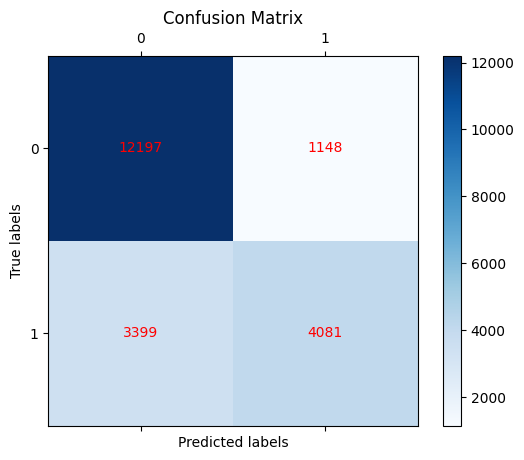

In [18]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')   
              
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

                                      Coefficient
PreviousCancellations                    0.785992
DepositType_Non Refund                   0.768211
Is_Country_PRT                           0.488671
LeadTime                                 0.442529
AssignedRoom_A                           0.351235
MarketSegment_Online TA                  0.332295
AverageDailyRate                         0.220569
ReservedRoom_F                           0.194286
CustomerType_Transient                   0.147342
ReservedRoom_D                           0.141548
ReservedRoom_E                           0.136882
StaysInWeekNights                        0.122892
ArrivalWeekNumber                        0.110585
BookingDistributionChannel_Corporate     0.101346
NumberOfAdult                            0.097581
TotalNights                              0.091143
Is_family                                0.075796
BookingMeal_SC                           0.067837
DepositType_Refundable                   0.061102


<Figure size 10000x4000 with 0 Axes>

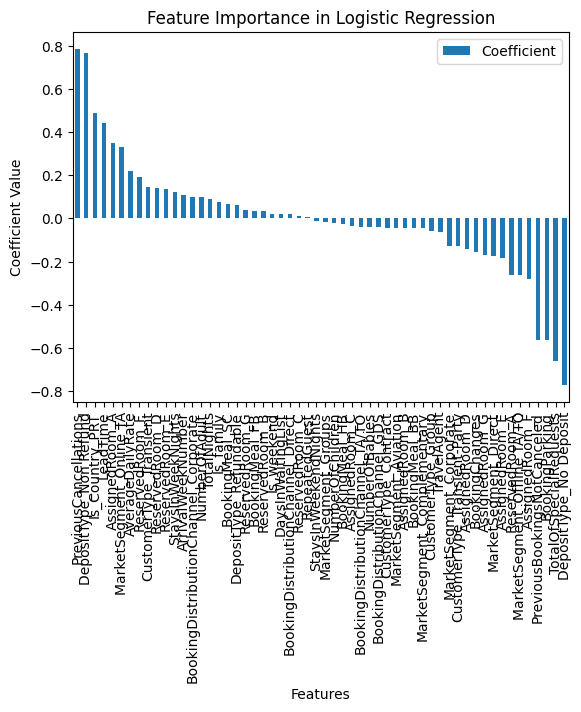

In [19]:
# Extract coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for easier interpretation
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

plt.figure(figsize=(100, 40))
feature_importance.plot(kind='bar')
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

### SVM

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(kernel='linear', C=1.0) 
svm_clf.fit(X_train_scaled, y_train)

SVC(kernel='linear')

Accuracy: 0.7809363745498199
Precision: 0.8613174839029223
Recall: 0.46497326203208555
F1 Score: 0.6039242924118771


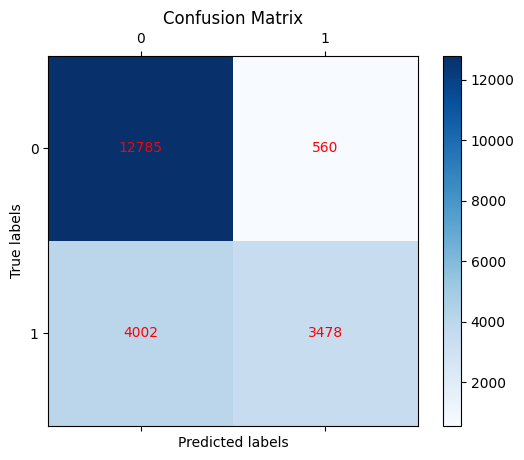

In [21]:
predictions = svm_clf.predict(X_test_scaled)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')   
              
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

In [22]:
# Get the weight coefficients
coefs = svm_clf.coef_[0]  # For binary classification, .coef_ is a 2D array

# The absolute value of the coefficients indicates importance
importance = np.abs(coefs)

# Example: Print the importance
print(importance)

[0.08433482 0.1625143  0.10760227 0.22042259 0.01366235 0.34247462
 0.0692752  0.02308671 0.01827098 0.42866125 0.6403547  0.01721929
 0.00624594 0.09373172 0.49248172 0.03426523 0.07151248 0.00311759
 0.07740326 0.26750337 0.14801985 0.02013802 0.01582185 0.03989703
 0.08644435 0.14254168 0.08678664 0.09695502 0.01004862 0.00372761
 0.04570933 0.06207073 0.08137119 0.01231288 0.05615286 0.00943558
 0.01568811 0.00402776 0.0242727  0.03245022 0.03255361 0.05098527
 0.01502795 0.01404373 0.08812673 0.08537141 0.33415556 0.33416109
 0.00482395 0.01885641 0.00702365 0.05583655 0.07837245 0.02102898
 0.15882676 0.19146247]


### Random Forest

In [23]:
clf = RandomForestClassifier(n_estimators=100, random_state=215)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=215)

Accuracy: 0.8109003601440576
Precision: 0.7931148626282688
Recall: 0.6406417112299465
F1 Score: 0.7087708918798994


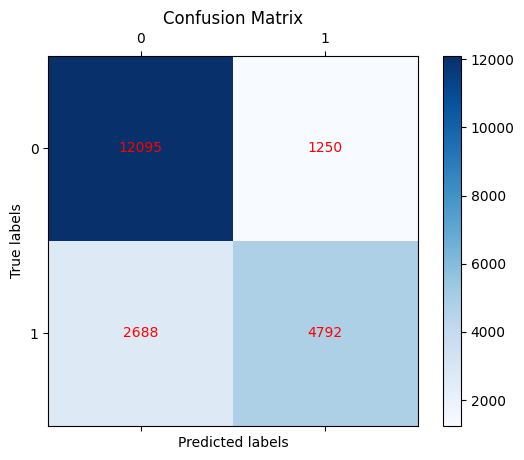

In [24]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 

print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

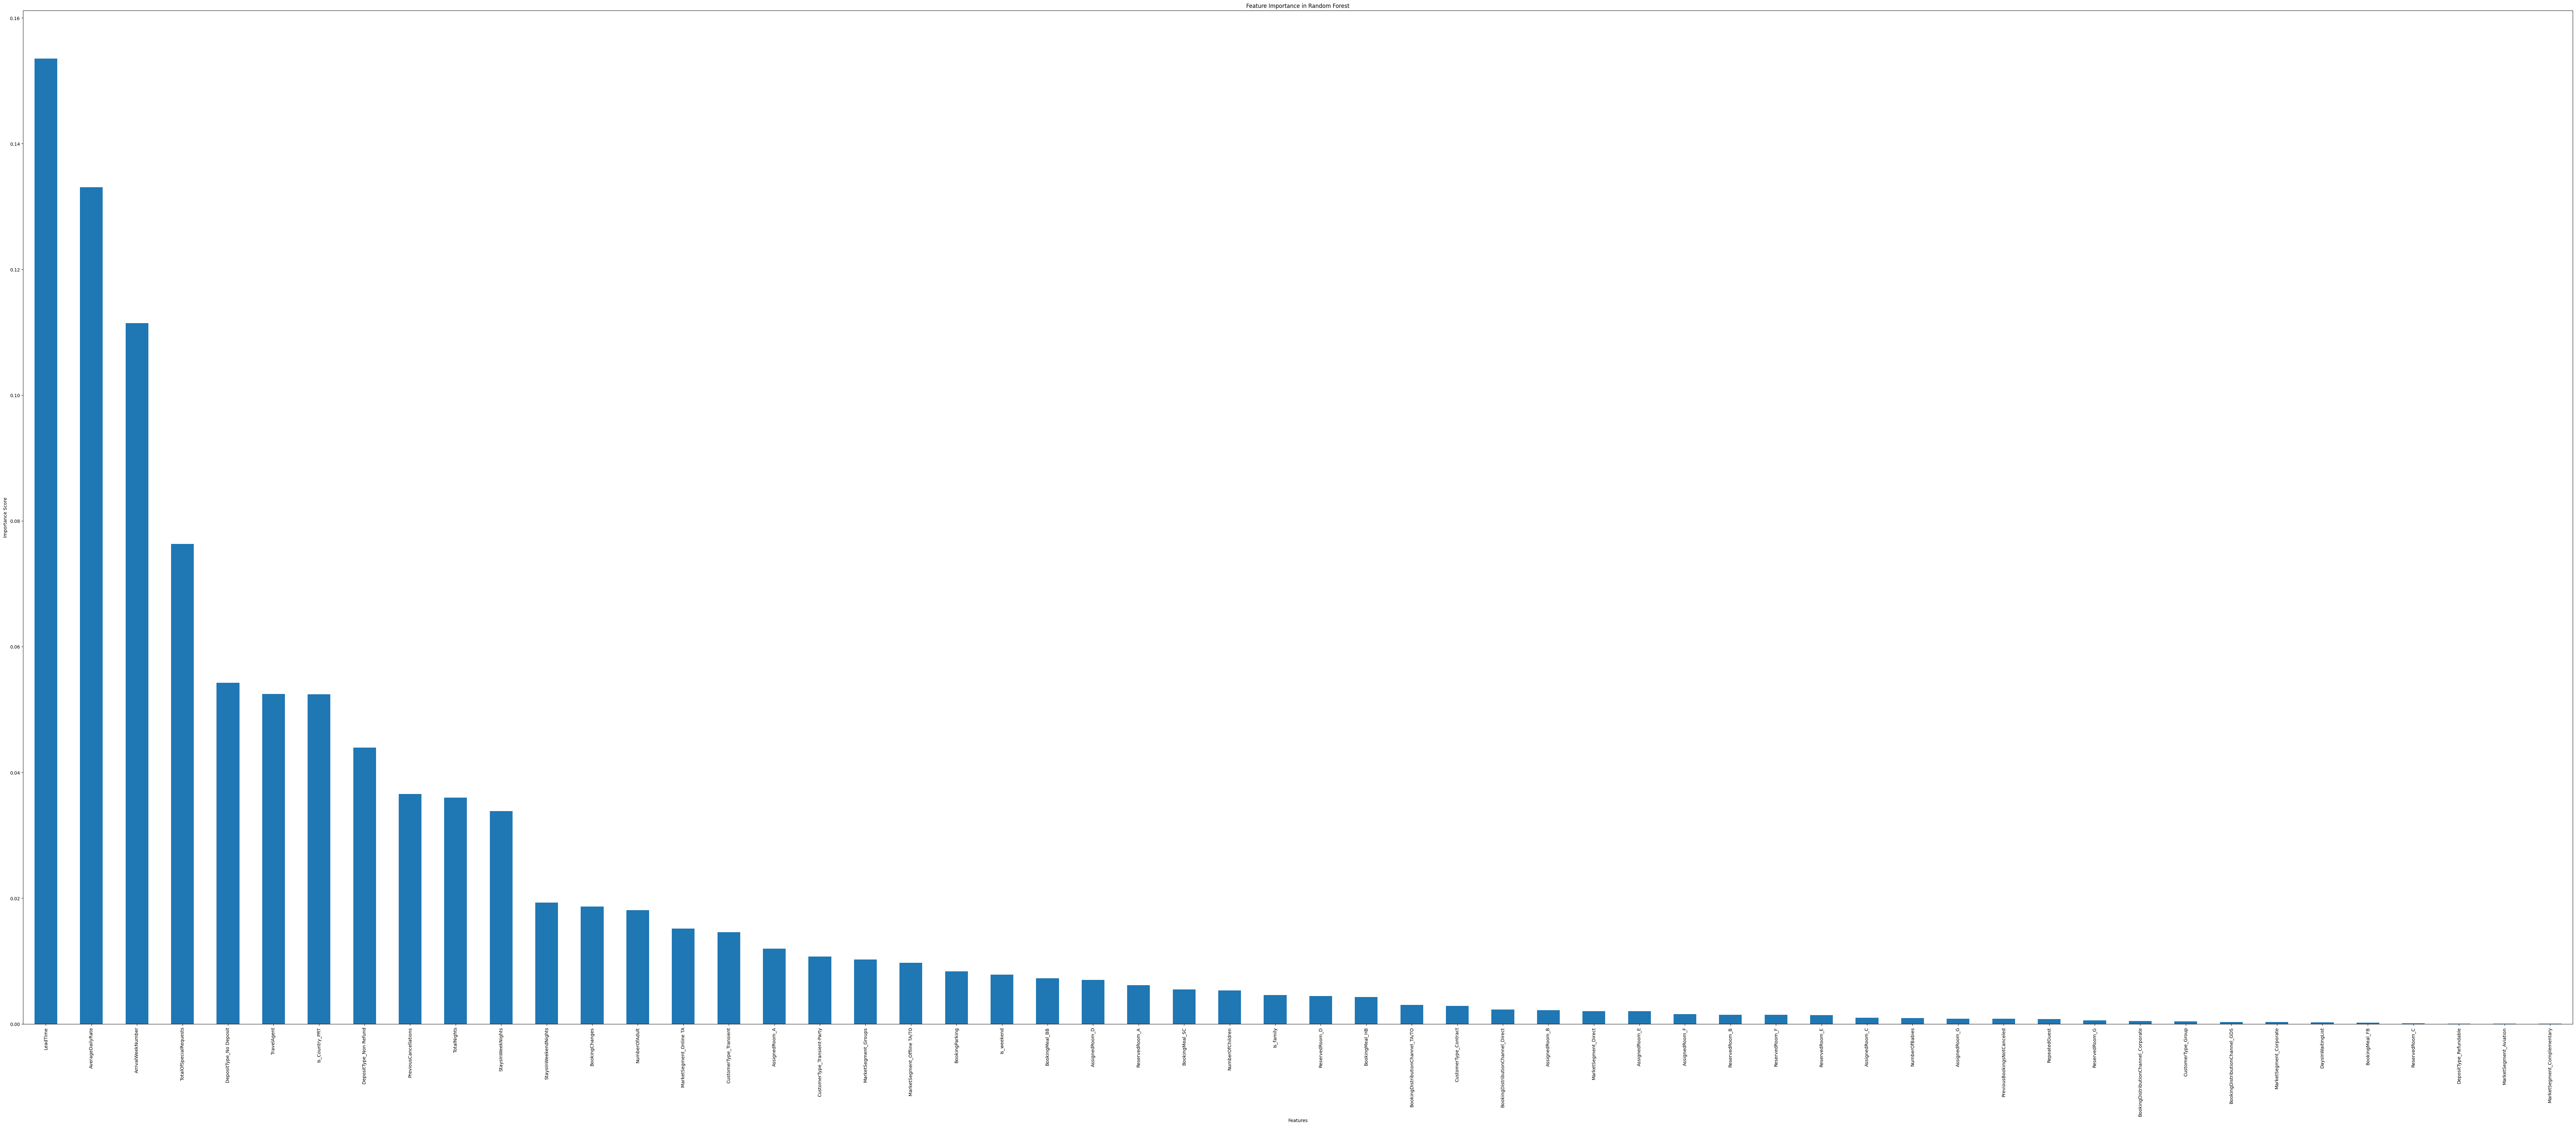

In [25]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series for easier plotting
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance in Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Features')

### XGboost

In [26]:
#XGBoost
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',enable_categorical = 'True')
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.8195438175270108
Precision: 0.7952093908629442
Recall: 0.670187165775401
F1 Score: 0.7273650609402206


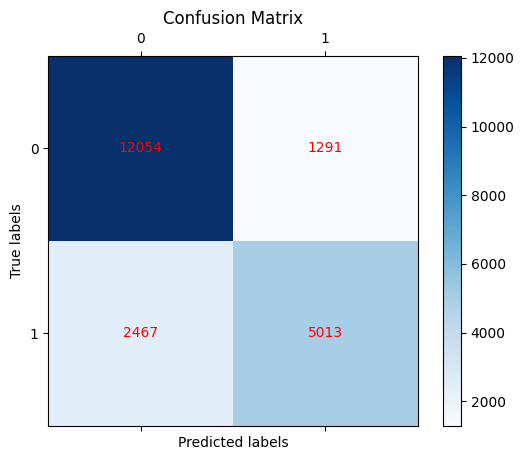

In [27]:
# Make predictions
predictions = clf.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 

print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

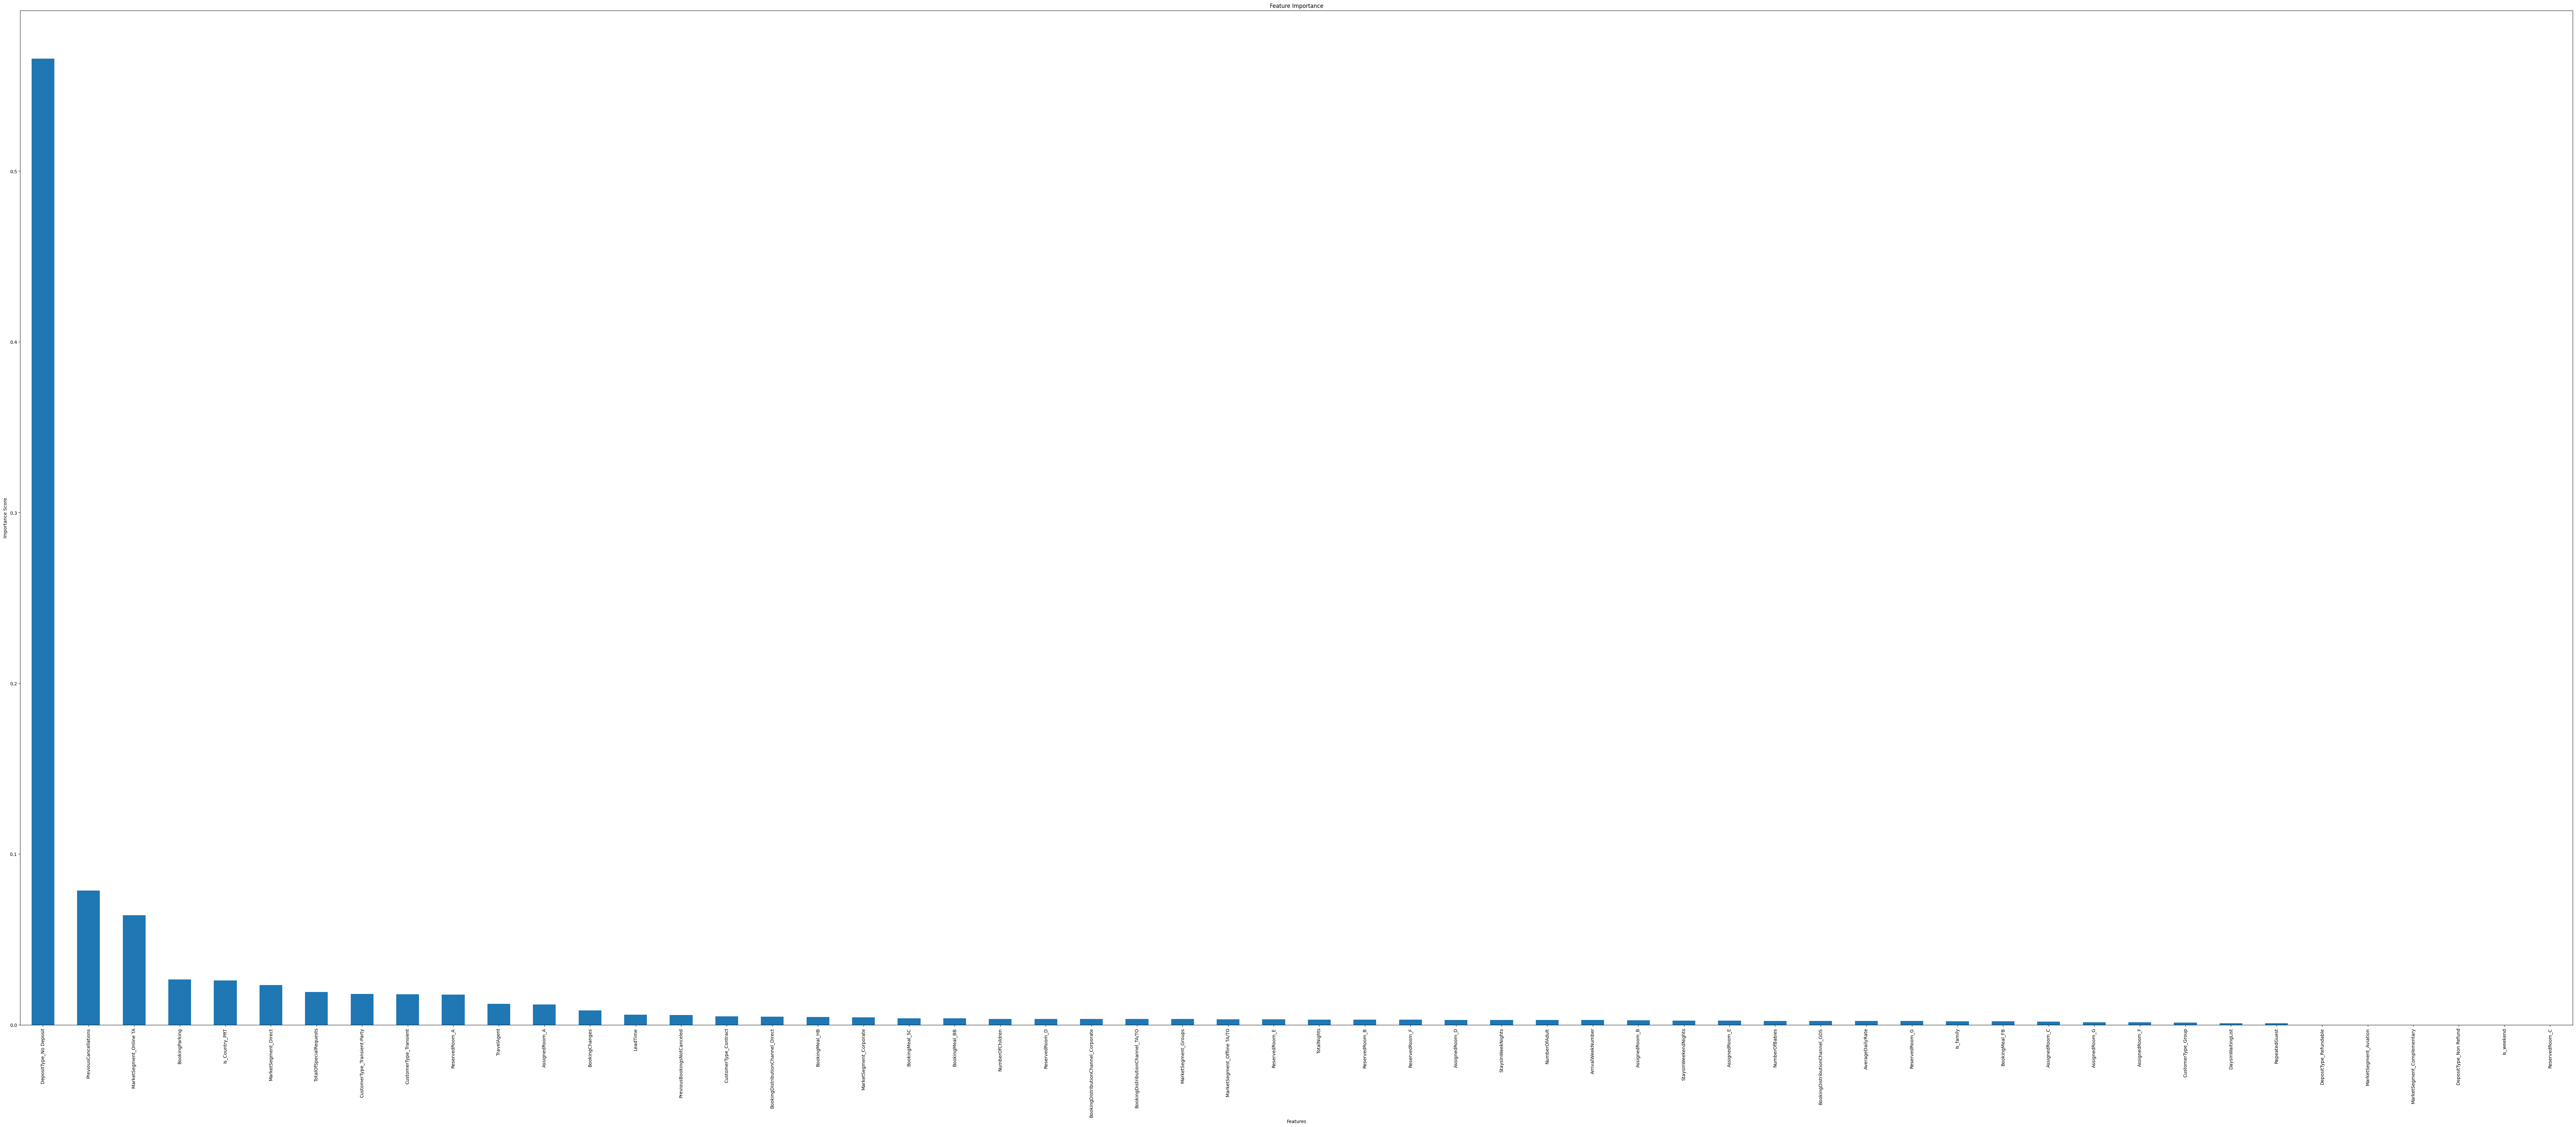

In [28]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series to make plotting easier
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')

# Early Cancellation and Late Cancellation

In [3]:
#read in raw data
Data  = pd.read_csv('/Users/shenglienlee/Desktop/GitHub/RIT_Competition/Data/Raw/R2_final_hotels.csv')
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0         8/14/17                 33            A             78.49   
1         4/24/17                 17            A            113.86   
2         8/25/15                 35            A             94.51   
3         8/15/17                 33            D            124.99   
4        10/12/16                 41            A            129.25   
...           ...                ...          ...               ...   
94359     9/18/17                 38            F            190.87   
94360     9/24/17                 38            A            171.88   
94361    11/28/17                 48            A             88.68   
94362     11/3/17                 44            A             72.41   
94363     9/19/17                 38            A            101.03   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          SC   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          HB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
94359               1             NaN                     Direct          BB   
94360               0             NaN                      TA/TO          BB   
94361               0             NaN                      TA/TO          SC   
94362               1             NaN                      TA/TO          SC   
94363               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousBookingsNotCanceled  \
0                 0.0     BRA  ...                           0   
1                 0.0     AUT  ...                           0   
2                 0.0     ITA  ...                           0   
3                 0.0     CHE  ...                           0   
4                 0.0     PRT  ...                           0   
...               ...     ...  ...                         ...   
94359             0.0     PRT  ...                           0   
94360             0.0     PRT  ...                           0   
94361             0.0     NLD  ...                           0   
94362             0.0     AUS  ...                           0   
94363             0.0     PRT  ...                           0   

       PreviousCancellations RepeatedGuest  ReservationStatus  \
0                          0             0          Check-Out   
1                          0             0          Check-Out   
2                          0             0           Canceled   
3                          0             0           Canceled   
4                          0             0          Check-Out   
...                      ...           ...                ...   
94359                      0             0          Check-Out   
94360                      1             0           Canceled   
94361                      0             0          Check-Out   
94362                      0             0          Check-Out   
94363                      0             0          Check-Out   

      ReservationStatusDate  ReservedRoom  StaysInWeekendNights  \
0                   8/21/17             A                     2   
1                   4/27/17             A                     2   
2                    7/9/15             A                     2   
3                    5/2/17             D                     1   
4                  10/16/16             A                     0   
...                     ...           ...                   ...   
94359               9/20/17             D                     1   
94360               7/23/17             A                     2   
94361          

In [4]:
#filter out cancellations
#label last minute cancellation(Arrivce date - canceled date <=3)  and not last minute cancellation

#Change data type to datetime
Data['ArrivalDate'] = pd.to_datetime(Data['ArrivalDate'], format='%m/%d/%y')
Data['ReservationStatusDate'] = pd.to_datetime(Data['ReservationStatusDate'], format='%m/%d/%y')

Data['days_difference'] = (Data['ArrivalDate']-Data['ReservationStatusDate']).dt.days


def Label_CancelType(row):
    #last minute cancellation #drop the record that has negative days_differnece
    if row['ReservationStatus'] == 'Canceled' and row['days_difference'] <= 3:
        return 2
    #early cancel
    elif row['ReservationStatus'] == 'Canceled'and row['days_difference'] > 3:
        return 1
    #no cancel
    else:
        return 0
Data['CancelType'] = Data.apply(Label_CancelType,axis = 1)

#Drop data cancel after arrivalDate
Data = Data.drop(Data[(Data['CancelType'] != 0) & (Data['days_difference'] < 0)].index)
#Drop 'ReservationStatus'
Data.drop('ReservationStatus', axis=1, inplace=True)

In [5]:
#filter out no cancellation data
Cancel_Data = Data[Data["CancelType"]!=0].reset_index(drop=True)
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
4      2016-05-19                 20            A             75.93   
...           ...                ...          ...               ...   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   
34723  2017-09-24                 38            A            171.88   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          HB   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          BB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
34719               0             NaN                      TA/TO          SC   
34720               0             NaN                      TA/TO          BB   
34721               0             NaN                      TA/TO          BB   
34722               0             NaN                      TA/TO          BB   
34723               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousCancellations  RepeatedGuest  \
0                 0.0     ITA  ...                     0              0   
1                 0.0     CHE  ...                     0              0   
2                 0.0     PRT  ...                     0              0   
3                 0.0     PRT  ...                     0              0   
4                 0.0     PRT  ...                     0              0   
...               ...     ...  ...                   ...            ...   
34719             0.0     CHN  ...                     0              0   
34720             0.0     PRT  ...                     0              0   
34721             0.0     DEU  ...                     0              0   
34722             0.0     FRA  ...                     0              0   
34723             0.0     PRT  ...                     1              0   

      ReservationStatusDate  ReservedRoom StaysInWeekendNights  \
0                2015-07-09             A                    2   
1                2017-05-02             D                    1   
2                2017-01-24             A                    0   
3                2017-04-12             A                    0   
4                2016-01-21             A                    0   
...                     ...           ...                  ...   
34719            2017-07-17             A                    1   
34720            2017-01-16             A                    1   
34721            2017-05-02             D                    1   
34722            2017-09-28             D                    1   
34723            2017-07-23             A                    2   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      1                       0         17.0   
1                      3                       1          9.0   
2                      2                       0        154.0   
3                      1                       1          9.0   
4                      4                       0         30.0   
...                  ...                     ...          ...   
34719                  2                   

In [6]:
#drop BookingCompany and other record contain null value
Cancel_Data.drop('BookingCompany', axis=1, inplace=True)
Cancel_Data = Cancel_Data.dropna()
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
4      2016-05-19                 20            A             75.93   
...           ...                ...          ...               ...   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   
34723  2017-09-24                 38            A            171.88   

       BookingChanges BookingDistributionChannel BookingMeal  BookingParking  \
0                   0                      TA/TO          HB             0.0   
1                   0                      TA/TO          BB             0.0   
2                   0                      TA/TO          BB             0.0   
3                   0                      TA/TO          BB             0.0   
4                   0                      TA/TO          BB             0.0   
...               ...                        ...         ...             ...   
34719               0                      TA/TO          SC             0.0   
34720               0                      TA/TO          BB             0.0   
34721               0                      TA/TO          BB             0.0   
34722               0                      TA/TO          BB             0.0   
34723               0                      TA/TO          BB             0.0   

      Country     CustomerType  ...  PreviousCancellations RepeatedGuest  \
0         ITA  Transient-Party  ...                      0             0   
1         CHE        Transient  ...                      0             0   
2         PRT        Transient  ...                      0             0   
3         PRT        Transient  ...                      0             0   
4         PRT  Transient-Party  ...                      0             0   
...       ...              ...  ...                    ...           ...   
34719     CHN        Transient  ...                      0             0   
34720     PRT        Transient  ...                      0             0   
34721     DEU        Transient  ...                      0             0   
34722     FRA        Transient  ...                      0             0   
34723     PRT  Transient-Party  ...                      1             0   

       ReservationStatusDate ReservedRoom  StaysInWeekendNights  \
0                 2015-07-09            A                     2   
1                 2017-05-02            D                     1   
2                 2017-01-24            A                     0   
3                 2017-04-12            A                     0   
4                 2016-01-21            A                     0   
...                      ...          ...                   ...   
34719             2017-07-17            A                     1   
34720             2017-01-16            A                     1   
34721             2017-05-02            D                     1   
34722             2017-09-28            D                     1   
34723             2017-07-23            A                     2   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      1                       0         17.0   
1                      3                       1          9.0   
2                      2                       0        154.0   
3                      1                       1          9.0   
4                      4                       0         30.0   
...                  ...                     ...          ...   
34719              

In [7]:
Cancel_Data.isnull().sum()

ArrivalDate                    0
ArrivalWeekNumber              0
AssignedRoom                   0
AverageDailyRate               0
BookingChanges                 0
BookingDistributionChannel     0
BookingMeal                    0
BookingParking                 0
Country                        0
CustomerType                   0
DaysInWaitingList              0
DepositType                    0
LeadTime                       0
MarketSegment                  0
NumberOfAdult                  0
NumberOfBabies                 0
NumberOfChildren               0
PreviousBookingsNotCanceled    0
PreviousCancellations          0
RepeatedGuest                  0
ReservationStatusDate          0
ReservedRoom                   0
StaysInWeekendNights           0
StaysInWeekNights              0
TotalOfSpecialRequests         0
TravelAgent                    0
days_difference                0
CancelType                     0
dtype: int64

## Preprocessing

In [8]:
Cancel_Data = Cancel_Data[Cancel_Data['AverageDailyRate'] > 0]
Cancel_Data  = Cancel_Data[Cancel_Data['LeadTime'] <= 300]
Cancel_Data = Cancel_Data[Cancel_Data['NumberOfAdult'] > 0]
Cancel_Data  = Cancel_Data[Cancel_Data['DaysInWaitingList'] <= 14]
Cancel_Data  = Cancel_Data[Cancel_Data['StaysInWeekNights'] + Cancel_Data['StaysInWeekendNights'] > 0]

In [9]:
Cancel_Data['ArrivalDate'] = pd.to_datetime(Cancel_Data['ArrivalDate'])

# Remove spaces from column AssignedRoom and ReservedRoom
Cancel_Data['AssignedRoom'] = Cancel_Data['AssignedRoom'].str.replace(' ','')
Cancel_Data['ReservedRoom'] = Cancel_Data['ReservedRoom'].str.replace(' ','')

In [10]:
# Family
Cancel_Data['Is_family'] = (Cancel_Data['NumberOfChildren'] > 0) | (Cancel_Data['NumberOfBabies'] > 0)
Cancel_Data['Is_family'] = Cancel_Data['Is_family'].astype(int)

In [11]:
# Weekend & total of night
Cancel_Data['Is_weekend'] = (Cancel_Data['StaysInWeekendNights'] > 0).astype(int)
Cancel_Data['TotalNights'] = Cancel_Data['StaysInWeekendNights'] + Cancel_Data['StaysInWeekNights']

In [12]:
Cancel_Data.drop('ArrivalDate', axis=1, inplace=True)
Cancel_Data.drop('ReservationStatusDate', axis=1, inplace=True)
Cancel_Data.drop('days_difference', axis=1, inplace=True)
Cancel_Data.drop('Country', axis=1, inplace=True)

In [13]:
Cancel_Data= pd.get_dummies(Cancel_Data, columns=['AssignedRoom', 'ReservedRoom','BookingDistributionChannel','BookingMeal','CustomerType','DepositType','MarketSegment'])
Cancel_Data

ArrivalWeekNumber  AverageDailyRate  BookingChanges  BookingParking  \
0                     35             94.51               0             0.0   
1                     33            124.99               0             0.0   
2                     24            130.17               0             0.0   
3                     21            120.90               0             0.0   
7                     42             89.62               0             0.0   
...                  ...               ...             ...             ...   
34718                 35            114.00               0             0.0   
34719                 38            108.55               0             0.0   
34720                 38            100.65               0             0.0   
34721                 36            196.94               0             0.0   
34722                 45             96.94               0             0.0   

       DaysInWaitingList  LeadTime  NumberOfAdult  NumberOfBabies  \
0                      0       117              2               0   
1                      0       265              2               0   
2                      0       151              2               0   
3                      0        86              2               0   
7                      0       279              2               0   
...                  ...       ...            ...             ...   
34718                  0       156              2               0   
34719                  0        15              2               0   
34720                  0        15              2               0   
34721                  0        10              1               0   
34722                  0        62              2               0   

       NumberOfChildren  PreviousBookingsNotCanceled  ...  \
0                   0.0                            0  ...   
1                   0.0                            0  ...   
2                   0.0                            0  ...   
3                   0.0                            0  ...   
7                   0.0                            0  ...   
...                 ...                          ...  ...   
34718               0.0                            0  ...   
34719               0.0                            0  ...   
34720               0.0                            0  ...   
34721               0.0                            0  ...   
34722               0.0                            0  ...   

       DepositType_No Deposit  DepositType_Non Refund  DepositType_Refundable  \
0                        True                   False                   False   
1                        True                   False                   False   
2                       False                    True                   False   
3                        True                   False                   False   
7                       False                    True                   False   
...                       ...                     ...                     ...   
34718                    True                   False                   False   
34719                    True                   False                   False   
34720                    True                   False                   False   
34721                    True                   False                   False   
34722                    True                   False                   False   

       MarketSegment_Aviation  MarketSegment_Complementary  \
0                       False                        False   
1                       False                        False   
2                       False                        False   
3                       False                        False   
7                       False                        False   
...                       ...                          ...   
34718                   False                        False   
34719                   False          

#### Issue
How to deal with Date Data

## Classification Model
1. normalization
2. Multicollinearly
3. data balancing

In [14]:
# If 'CancelType' is your target variable
y = Cancel_Data['CancelType']

# Drop the target variable from the feature set
X = Cancel_Data.drop('CancelType', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=215)
feature_names = X_train.columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### Logistic Regression

In [15]:
clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model 
clf.fit(X_train_scaled, y_train)


LogisticRegression(random_state=42, solver='liblinear')

Accuracy: 0.9699046083568453
Precision: 0.9699046083568453
Recall: 1.0
F1 Score: 0.9847224116764425


/Users/shenglienlee/anaconda3/envs/RIT_Competition/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


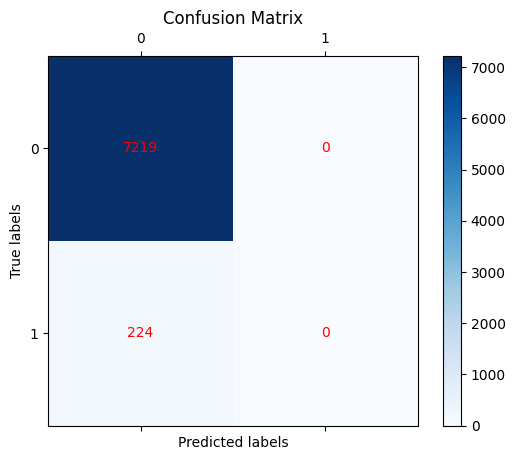

In [16]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')   
              
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

                                      Coefficient
NumberOfChildren                         0.188176
MarketSegment_Direct                     0.125362
TotalOfSpecialRequests                   0.094318
MarketSegment_Corporate                  0.093077
DepositType_No Deposit                   0.087318
AssignedRoom_B                           0.083830
CustomerType_Transient-Party             0.073623
BookingDistributionChannel_GDS           0.065934
ReservedRoom_F                           0.064806
MarketSegment_Offline TA/TO              0.060938
BookingDistributionChannel_TA/TO         0.056189
RepeatedGuest                            0.053594
BookingMeal_SC                           0.044146
NumberOfBabies                           0.041433
DepositType_Refundable                   0.039151
ReservedRoom_D                           0.037584
NumberOfAdult                            0.033858
ReservedRoom_G                           0.025892
MarketSegment_Groups                     0.024373


<Figure size 10000x4000 with 0 Axes>

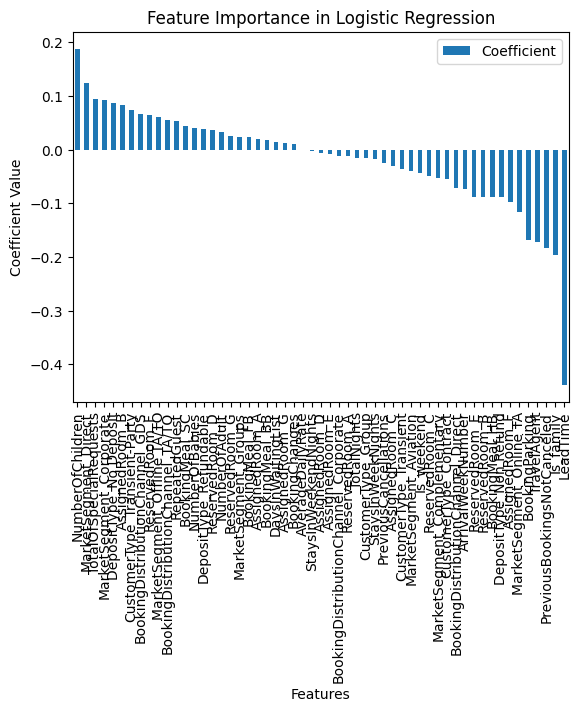

In [17]:
# Extract coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for easier interpretation
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

plt.figure(figsize=(100, 40))
feature_importance.plot(kind='bar')
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

### SVM

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(kernel='linear', C=1.0) 
svm_clf.fit(X_train_scaled, y_train)

SVC(kernel='linear')

Accuracy: 0.9699046083568453
Precision: 0.9699046083568453
Recall: 1.0
F1 Score: 0.9847224116764425


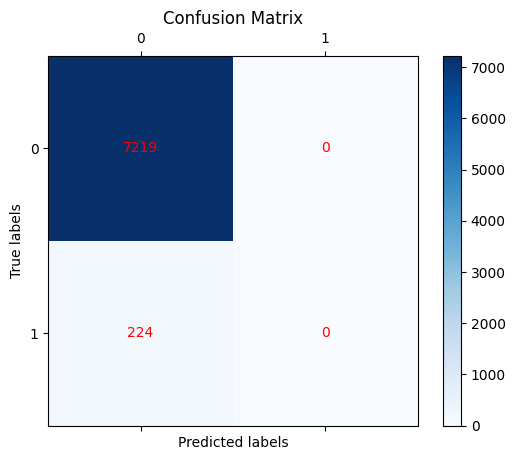

In [19]:
predictions = svm_clf.predict(X_test_scaled)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')   
              
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

In [20]:
# Get the weight coefficients
coefs = svm_clf.coef_[0]  # For binary classification, .coef_ is a 2D array

# The absolute value of the coefficients indicates importance
importance = np.abs(coefs)

# Example: Print the importance
print(importance)

[2.90147343e-06 5.37655881e-06 6.92081623e-06 4.66671783e-06
 2.12013204e-06 5.99981363e-06 5.13741482e-06 1.39856255e-05
 3.74235290e-05 4.56099402e-05 1.22621349e-06 9.24150947e-06
 1.25367513e-05 9.49840215e-06 1.12677688e-05 2.49346246e-06
 4.43036007e-05 2.01212766e-05 1.64664233e-06 1.60871000e-06
 1.59794954e-05 4.40390496e-06 6.78352753e-06 3.91358677e-06
 3.15708215e-06 2.76101282e-07 2.89631772e-06 5.17896227e-06
 1.17683641e-14 2.63039709e-06 1.46348327e-05 7.99985952e-06
 2.02870850e-06 4.31662519e-06 5.94319024e-06 1.44144303e-06
 7.27220951e-06 6.19389266e-06 1.67637863e-06 9.31925421e-06
 5.19768771e-08 6.18852425e-06 3.52350423e-06 6.58308955e-06
 3.28403082e-06 6.95039257e-06 7.06928637e-06 2.93796711e-06
 1.08836551e-14 4.68271255e-14 8.61191529e-06 1.18447065e-05
 9.13841645e-06 1.09066804e-05 1.89297094e-05]


### Random Forest

In [21]:
clf = RandomForestClassifier(n_estimators=100, random_state=215)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=215)

Accuracy: 0.9701733172108021
Precision: 0.9702917058744455
Recall: 0.999861476658817
F1 Score: 0.9848546868604175


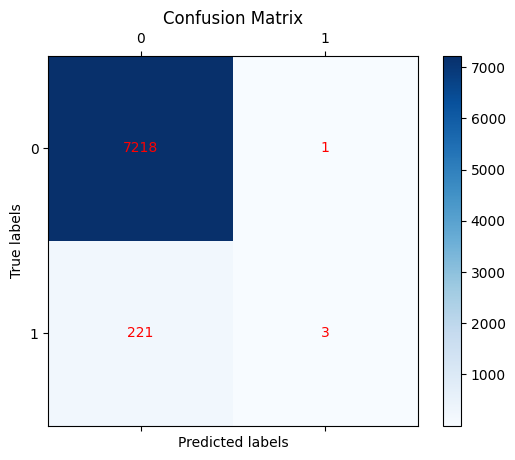

In [22]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 

print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

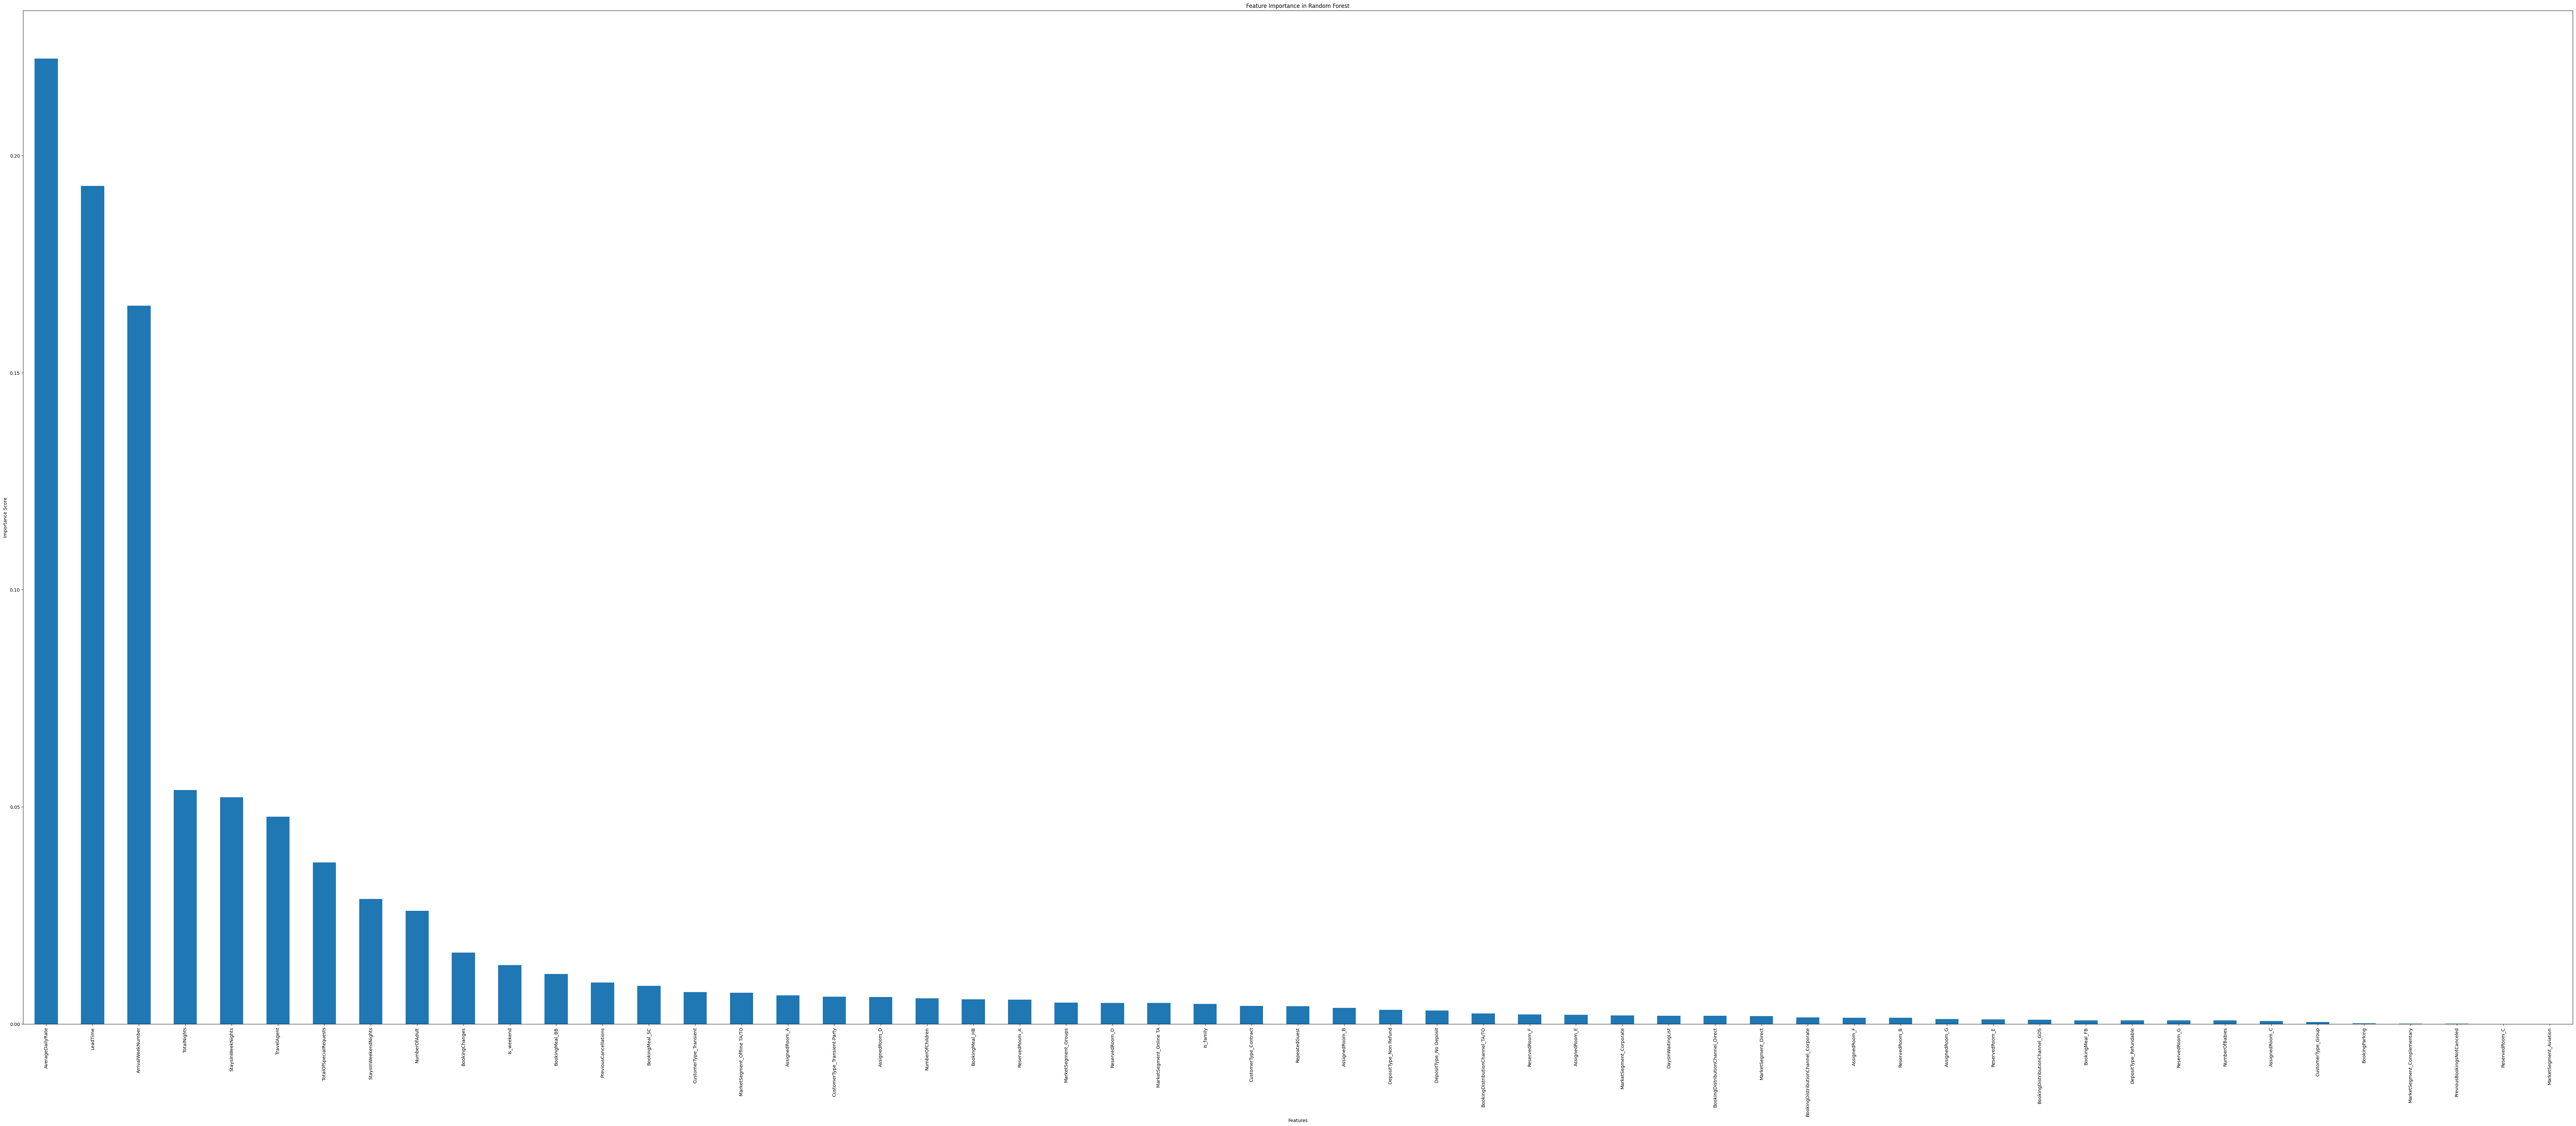

In [23]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series for easier plotting
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance in Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Features')

### XGboost

In [24]:
y_train = y_train.reset_index(drop=True)
for i in range(len(y_train)):
    y_train[i] = y_train[i] - 1

y_test = y_test.reset_index(drop=True)
for i in range(len(y_test)):
    y_test[i] = y_test[i] - 1

In [25]:
#XGBoost
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',enable_categorical = 'True')
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.9700389627838237
Precision: 0.6
Recall: 0.013392857142857142
F1 Score: 0.026200873362445413


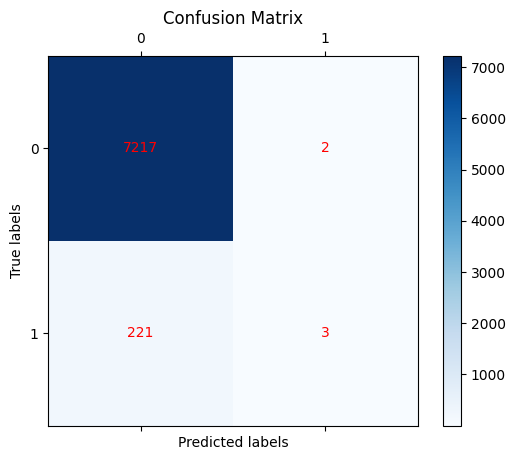

In [26]:
# Make predictions
predictions = clf.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 

print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

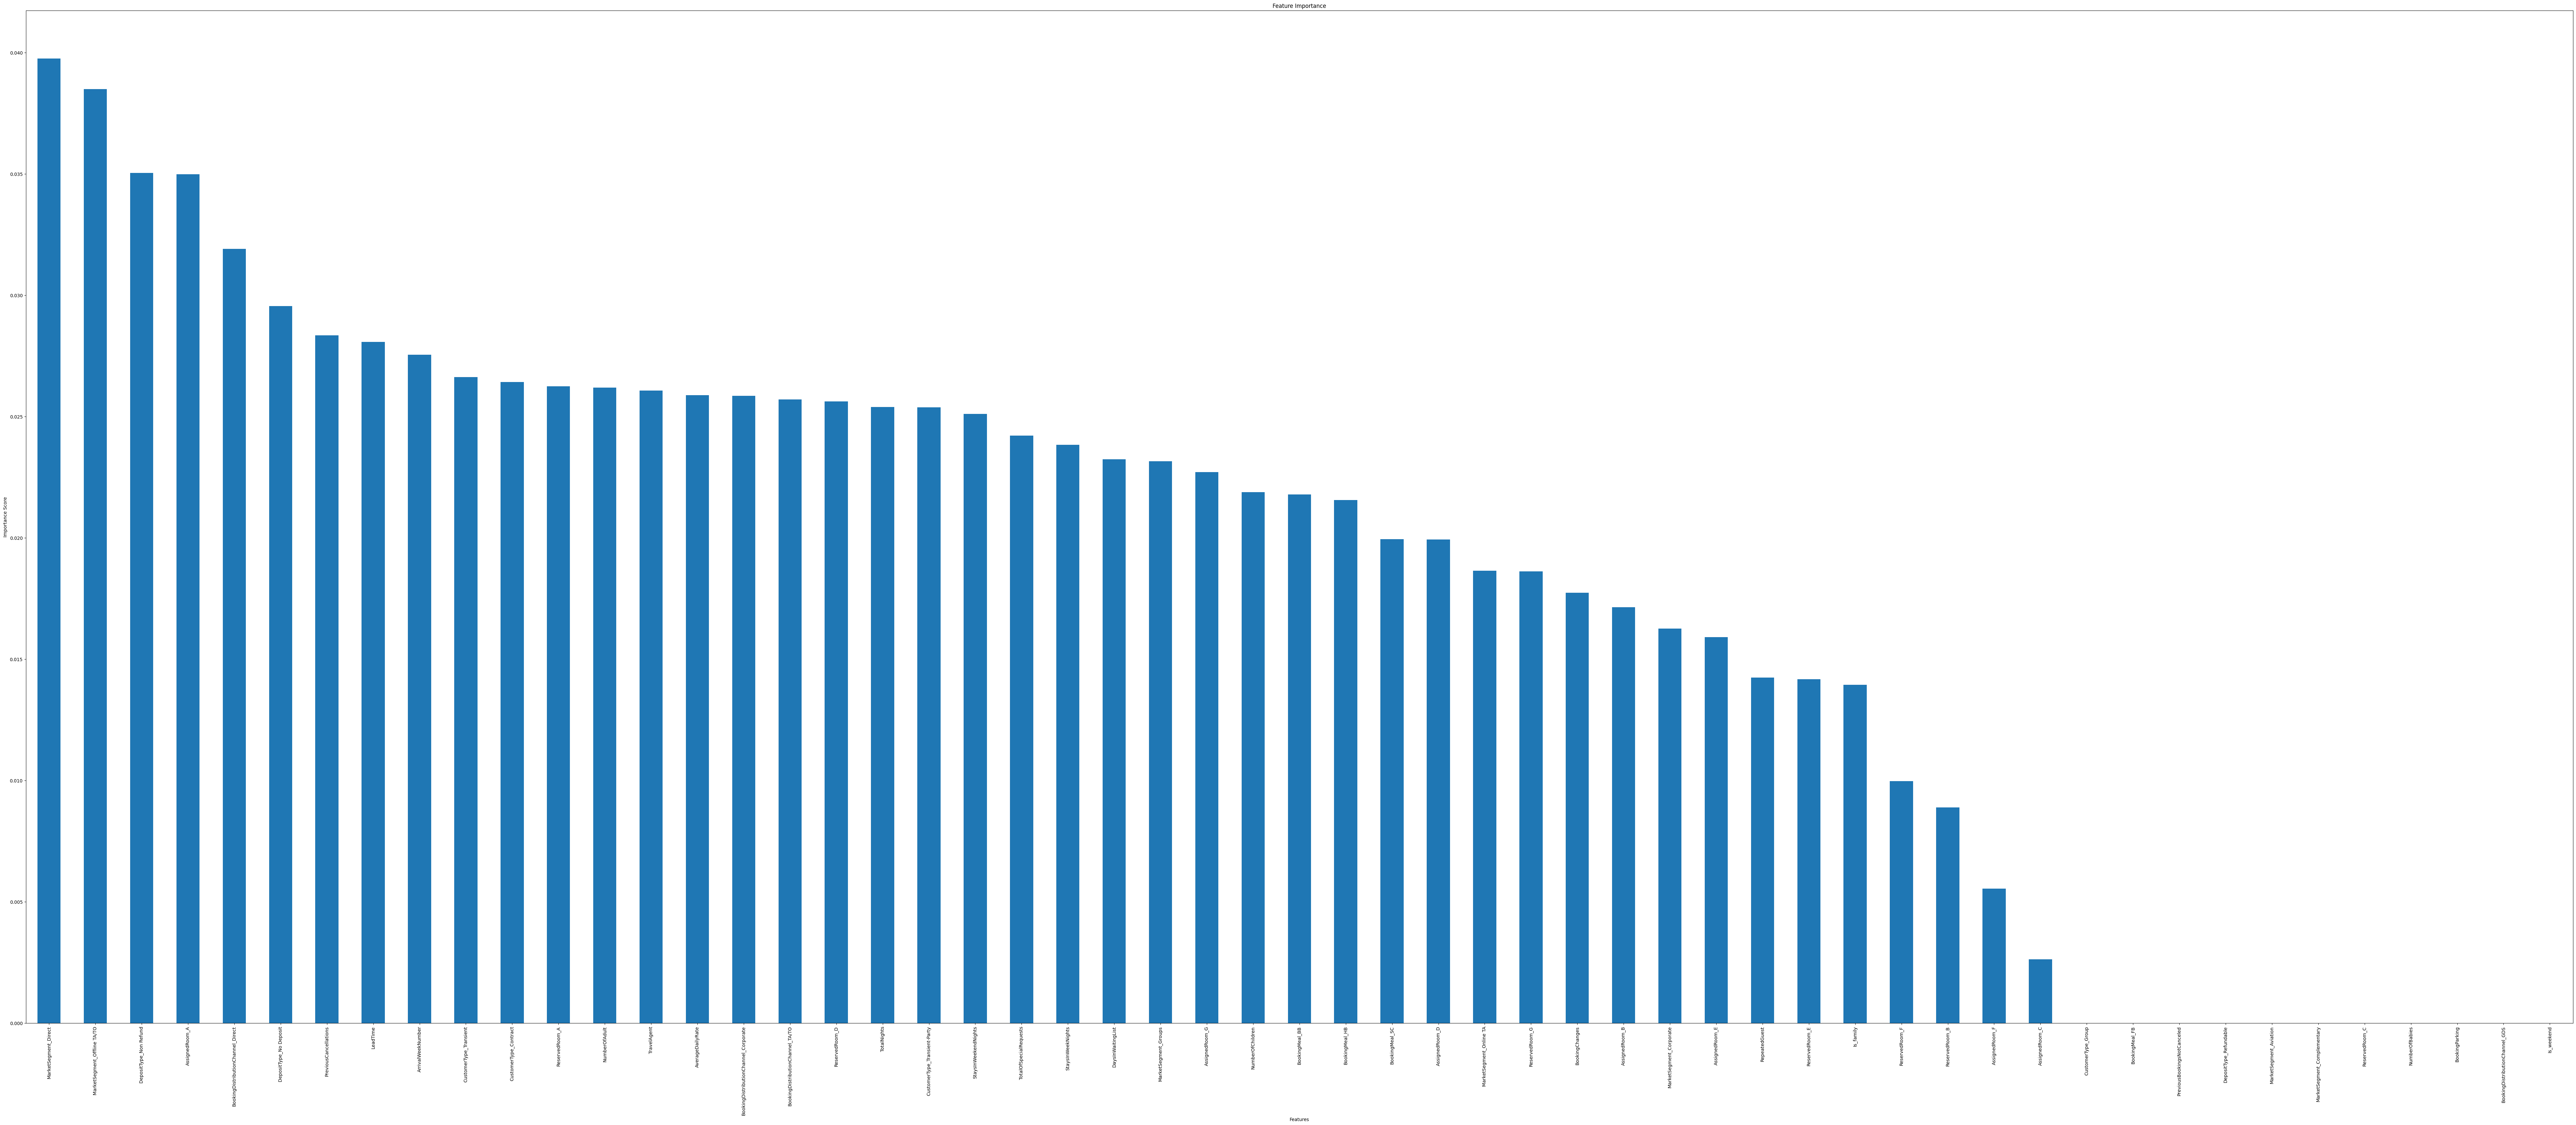

In [27]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series to make plotting easier
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')

# Data Imbalanced

## Data Processing

In [2]:
from imblearn.over_sampling import SMOTE

In [3]:
#read in raw data
Data  = pd.read_csv('/Users/shenglienlee/Desktop/GitHub/RIT_Competition/Data/Raw/R2_final_hotels.csv')
Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0         8/14/17                 33            A             78.49   
1         4/24/17                 17            A            113.86   
2         8/25/15                 35            A             94.51   
3         8/15/17                 33            D            124.99   
4        10/12/16                 41            A            129.25   
...           ...                ...          ...               ...   
94359     9/18/17                 38            F            190.87   
94360     9/24/17                 38            A            171.88   
94361    11/28/17                 48            A             88.68   
94362     11/3/17                 44            A             72.41   
94363     9/19/17                 38            A            101.03   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          SC   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          HB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
94359               1             NaN                     Direct          BB   
94360               0             NaN                      TA/TO          BB   
94361               0             NaN                      TA/TO          SC   
94362               1             NaN                      TA/TO          SC   
94363               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousBookingsNotCanceled  \
0                 0.0     BRA  ...                           0   
1                 0.0     AUT  ...                           0   
2                 0.0     ITA  ...                           0   
3                 0.0     CHE  ...                           0   
4                 0.0     PRT  ...                           0   
...               ...     ...  ...                         ...   
94359             0.0     PRT  ...                           0   
94360             0.0     PRT  ...                           0   
94361             0.0     NLD  ...                           0   
94362             0.0     AUS  ...                           0   
94363             0.0     PRT  ...                           0   

       PreviousCancellations RepeatedGuest  ReservationStatus  \
0                          0             0          Check-Out   
1                          0             0          Check-Out   
2                          0             0           Canceled   
3                          0             0           Canceled   
4                          0             0          Check-Out   
...                      ...           ...                ...   
94359                      0             0          Check-Out   
94360                      1             0           Canceled   
94361                      0             0          Check-Out   
94362                      0             0          Check-Out   
94363                      0             0          Check-Out   

      ReservationStatusDate  ReservedRoom  StaysInWeekendNights  \
0                   8/21/17             A                     2   
1                   4/27/17             A                     2   
2                    7/9/15             A                     2   
3                    5/2/17             D                     1   
4                  10/16/16             A                     0   
...                     ...           ...                   ...   
94359               9/20/17             D                     1   
94360               7/23/17             A                     2   
94361          

In [4]:
#filter out cancellations
#label last minute cancellation(Arrivce date - canceled date <=3)  and not last minute cancellation

#Change data type to datetime
Data['ArrivalDate'] = pd.to_datetime(Data['ArrivalDate'], format='%m/%d/%y')
Data['ReservationStatusDate'] = pd.to_datetime(Data['ReservationStatusDate'], format='%m/%d/%y')

Data['days_difference'] = (Data['ArrivalDate']-Data['ReservationStatusDate']).dt.days


def Label_CancelType(row):
    #last minute cancellation #drop the record that has negative days_differnece
    if row['ReservationStatus'] == 'Canceled' and row['days_difference'] <= 3:
        return 2
    #early cancel
    elif row['ReservationStatus'] == 'Canceled'and row['days_difference'] > 3:
        return 1
    #no cancel
    else:
        return 0
Data['CancelType'] = Data.apply(Label_CancelType,axis = 1)

#Drop data cancel after arrivalDate
Data = Data.drop(Data[(Data['CancelType'] != 0) & (Data['days_difference'] < 0)].index)

#Drop 'ReservationStatus'
Data.drop('ReservationStatus', axis=1, inplace=True)


In [5]:
#filter out no cancellation data
Cancel_Data = Data[Data["CancelType"]!=0].reset_index(drop=True)
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
4      2016-05-19                 20            A             75.93   
...           ...                ...          ...               ...   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   
34723  2017-09-24                 38            A            171.88   

       BookingChanges  BookingCompany BookingDistributionChannel BookingMeal  \
0                   0             NaN                      TA/TO          HB   
1                   0             NaN                      TA/TO          BB   
2                   0             NaN                      TA/TO          BB   
3                   0             NaN                      TA/TO          BB   
4                   0             NaN                      TA/TO          BB   
...               ...             ...                        ...         ...   
34719               0             NaN                      TA/TO          SC   
34720               0             NaN                      TA/TO          BB   
34721               0             NaN                      TA/TO          BB   
34722               0             NaN                      TA/TO          BB   
34723               0             NaN                      TA/TO          BB   

       BookingParking Country  ... PreviousCancellations  RepeatedGuest  \
0                 0.0     ITA  ...                     0              0   
1                 0.0     CHE  ...                     0              0   
2                 0.0     PRT  ...                     0              0   
3                 0.0     PRT  ...                     0              0   
4                 0.0     PRT  ...                     0              0   
...               ...     ...  ...                   ...            ...   
34719             0.0     CHN  ...                     0              0   
34720             0.0     PRT  ...                     0              0   
34721             0.0     DEU  ...                     0              0   
34722             0.0     FRA  ...                     0              0   
34723             0.0     PRT  ...                     1              0   

      ReservationStatusDate  ReservedRoom StaysInWeekendNights  \
0                2015-07-09             A                    2   
1                2017-05-02             D                    1   
2                2017-01-24             A                    0   
3                2017-04-12             A                    0   
4                2016-01-21             A                    0   
...                     ...           ...                  ...   
34719            2017-07-17             A                    1   
34720            2017-01-16             A                    1   
34721            2017-05-02             D                    1   
34722            2017-09-28             D                    1   
34723            2017-07-23             A                    2   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      1                       0         17.0   
1                      3                       1          9.0   
2                      2                       0        154.0   
3                      1                       1          9.0   
4                      4                       0         30.0   
...                  ...                     ...          ...   
34719                  2                   

In [6]:
#drop BookingCompany
Cancel_Data.drop('BookingCompany', axis=1, inplace=True)
Cancel_Data = Cancel_Data.dropna()
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
4      2016-05-19                 20            A             75.93   
...           ...                ...          ...               ...   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   
34723  2017-09-24                 38            A            171.88   

       BookingChanges BookingDistributionChannel BookingMeal  BookingParking  \
0                   0                      TA/TO          HB             0.0   
1                   0                      TA/TO          BB             0.0   
2                   0                      TA/TO          BB             0.0   
3                   0                      TA/TO          BB             0.0   
4                   0                      TA/TO          BB             0.0   
...               ...                        ...         ...             ...   
34719               0                      TA/TO          SC             0.0   
34720               0                      TA/TO          BB             0.0   
34721               0                      TA/TO          BB             0.0   
34722               0                      TA/TO          BB             0.0   
34723               0                      TA/TO          BB             0.0   

      Country     CustomerType  ...  PreviousCancellations RepeatedGuest  \
0         ITA  Transient-Party  ...                      0             0   
1         CHE        Transient  ...                      0             0   
2         PRT        Transient  ...                      0             0   
3         PRT        Transient  ...                      0             0   
4         PRT  Transient-Party  ...                      0             0   
...       ...              ...  ...                    ...           ...   
34719     CHN        Transient  ...                      0             0   
34720     PRT        Transient  ...                      0             0   
34721     DEU        Transient  ...                      0             0   
34722     FRA        Transient  ...                      0             0   
34723     PRT  Transient-Party  ...                      1             0   

       ReservationStatusDate ReservedRoom  StaysInWeekendNights  \
0                 2015-07-09            A                     2   
1                 2017-05-02            D                     1   
2                 2017-01-24            A                     0   
3                 2017-04-12            A                     0   
4                 2016-01-21            A                     0   
...                      ...          ...                   ...   
34719             2017-07-17            A                     1   
34720             2017-01-16            A                     1   
34721             2017-05-02            D                     1   
34722             2017-09-28            D                     1   
34723             2017-07-23            A                     2   

       StaysInWeekNights  TotalOfSpecialRequests  TravelAgent  \
0                      1                       0         17.0   
1                      3                       1          9.0   
2                      2                       0        154.0   
3                      1                       1          9.0   
4                      4                       0         30.0   
...                  ...                     ...          ...   
34719              

In [7]:
Cancel_Data = Cancel_Data[Cancel_Data['AverageDailyRate'] > 0]
Cancel_Data = Cancel_Data[Cancel_Data['LeadTime'] <= 300]
Cancel_Data = Cancel_Data[Cancel_Data['NumberOfAdult'] > 0]
Cancel_Data = Cancel_Data[Cancel_Data['DaysInWaitingList'] <= 14]
Cancel_Data = Cancel_Data[Cancel_Data['StaysInWeekNights'] + Cancel_Data['StaysInWeekendNights'] > 0]

In [8]:
Cancel_Data['ArrivalDate'] = pd.to_datetime(Cancel_Data['ArrivalDate'])

# Remove spaces from column AssignedRoom and ReservedRoom
Cancel_Data['AssignedRoom'] = Cancel_Data['AssignedRoom'].str.replace(' ','')
Cancel_Data['ReservedRoom'] = Cancel_Data['ReservedRoom'].str.replace(' ','')

In [9]:
# Family
Cancel_Data['Is_family'] = (Cancel_Data['NumberOfChildren'] > 0) | (Cancel_Data['NumberOfBabies'] > 0)
Cancel_Data['Is_family'] = Cancel_Data['Is_family'].astype(int)

In [10]:
# Weekend & total of night
Cancel_Data['Is_weekend'] = (Cancel_Data['StaysInWeekendNights'] > 0).astype(int)
Cancel_Data['TotalNights'] = Cancel_Data['StaysInWeekendNights'] + Cancel_Data['StaysInWeekNights']

In [11]:
#Add new Column Is_Country_PRT(1 means yes)
Cancel_Data['Is_Country_PRT'] = (Cancel_Data['Country'] == 'PRT').astype(int)
Cancel_Data

ArrivalDate  ArrivalWeekNumber AssignedRoom  AverageDailyRate  \
0      2015-08-25                 35            A             94.51   
1      2017-08-15                 33            D            124.99   
2      2017-06-12                 24            A            130.17   
3      2017-05-24                 21            A            120.90   
7      2015-10-16                 42            A             89.62   
...           ...                ...          ...               ...   
34718  2017-09-02                 35            D            114.00   
34719  2017-09-23                 38            A            108.55   
34720  2017-09-22                 38            A            100.65   
34721  2017-09-06                 36            E            196.94   
34722  2017-11-10                 45            D             96.94   

       BookingChanges BookingDistributionChannel BookingMeal  BookingParking  \
0                   0                      TA/TO          HB             0.0   
1                   0                      TA/TO          BB             0.0   
2                   0                      TA/TO          BB             0.0   
3                   0                      TA/TO          BB             0.0   
7                   0                      TA/TO          HB             0.0   
...               ...                        ...         ...             ...   
34718               0                      TA/TO          BB             0.0   
34719               0                      TA/TO          SC             0.0   
34720               0                      TA/TO          BB             0.0   
34721               0                      TA/TO          BB             0.0   
34722               0                      TA/TO          BB             0.0   

      Country     CustomerType  ...  StaysInWeekendNights StaysInWeekNights  \
0         ITA  Transient-Party  ...                     2                 1   
1         CHE        Transient  ...                     1                 3   
2         PRT        Transient  ...                     0                 2   
3         PRT        Transient  ...                     0                 1   
7         PRT        Transient  ...                     0                 2   
...       ...              ...  ...                   ...               ...   
34718     ESP        Transient  ...                     2                 2   
34719     CHN        Transient  ...                     1                 2   
34720     PRT        Transient  ...                     1                 3   
34721     DEU        Transient  ...                     1                 4   
34722     FRA        Transient  ...                     1                 2   

       TotalOfSpecialRequests TravelAgent  days_difference  CancelType  \
0                           0        17.0               47           1   
1                           1         9.0              105           1   
2                           0       154.0              139           1   
3                           1         9.0               42           1   
7                           0         1.0               98           1   
...                       ...         ...              ...         ...   
34718                       0         9.0               86           1   
34719                       0         9.0               68           1   
34720                       0        37.0              249           1   
34721                       0         9.0              127           1   
34722                       2         9.0               43           1   

       Is_family  Is_weekend  TotalNights  Is_Country_PRT  
0              0           1            3               0  
1              0           1            4               0  
2              0           0            2               1  
3              0           0            1               1  
7              0           0            2             

In [12]:
Cancel_Data.drop('ArrivalDate', axis=1, inplace=True)
Cancel_Data.drop('ReservationStatusDate', axis=1, inplace=True)
Cancel_Data.drop('days_difference', axis=1, inplace=True)
Cancel_Data.drop('Country', axis=1, inplace=True)

In [13]:
#One Hot Enocde Categorical data
Cancel_Data= pd.get_dummies(Cancel_Data, columns=['AssignedRoom', 'ReservedRoom','BookingDistributionChannel','BookingMeal','CustomerType','DepositType','MarketSegment'])
Cancel_Data

ArrivalWeekNumber  AverageDailyRate  BookingChanges  BookingParking  \
0                     35             94.51               0             0.0   
1                     33            124.99               0             0.0   
2                     24            130.17               0             0.0   
3                     21            120.90               0             0.0   
7                     42             89.62               0             0.0   
...                  ...               ...             ...             ...   
34718                 35            114.00               0             0.0   
34719                 38            108.55               0             0.0   
34720                 38            100.65               0             0.0   
34721                 36            196.94               0             0.0   
34722                 45             96.94               0             0.0   

       DaysInWaitingList  LeadTime  NumberOfAdult  NumberOfBabies  \
0                      0       117              2               0   
1                      0       265              2               0   
2                      0       151              2               0   
3                      0        86              2               0   
7                      0       279              2               0   
...                  ...       ...            ...             ...   
34718                  0       156              2               0   
34719                  0        15              2               0   
34720                  0        15              2               0   
34721                  0        10              1               0   
34722                  0        62              2               0   

       NumberOfChildren  PreviousBookingsNotCanceled  ...  \
0                   0.0                            0  ...   
1                   0.0                            0  ...   
2                   0.0                            0  ...   
3                   0.0                            0  ...   
7                   0.0                            0  ...   
...                 ...                          ...  ...   
34718               0.0                            0  ...   
34719               0.0                            0  ...   
34720               0.0                            0  ...   
34721               0.0                            0  ...   
34722               0.0                            0  ...   

       DepositType_No Deposit  DepositType_Non Refund  DepositType_Refundable  \
0                        True                   False                   False   
1                        True                   False                   False   
2                       False                    True                   False   
3                        True                   False                   False   
7                       False                    True                   False   
...                       ...                     ...                     ...   
34718                    True                   False                   False   
34719                    True                   False                   False   
34720                    True                   False                   False   
34721                    True                   False                   False   
34722                    True                   False                   False   

       MarketSegment_Aviation  MarketSegment_Complementary  \
0                       False                        False   
1                       False                        False   
2                       False                        False   
3                       False                        False   
7                       False                        False   
...                       ...                          ...   
34718                   False                        False   
34719                   False          

## Oversampling     

In [116]:
# If 'CancelType' is your target variable
y = Cancel_Data['CancelType']

# Drop the target variable from the feature set
X = Cancel_Data.drop('CancelType', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=215)
feature_names = X_train.columns

In [117]:
# Apply SMOTE for oversampling the minority class in the training set
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

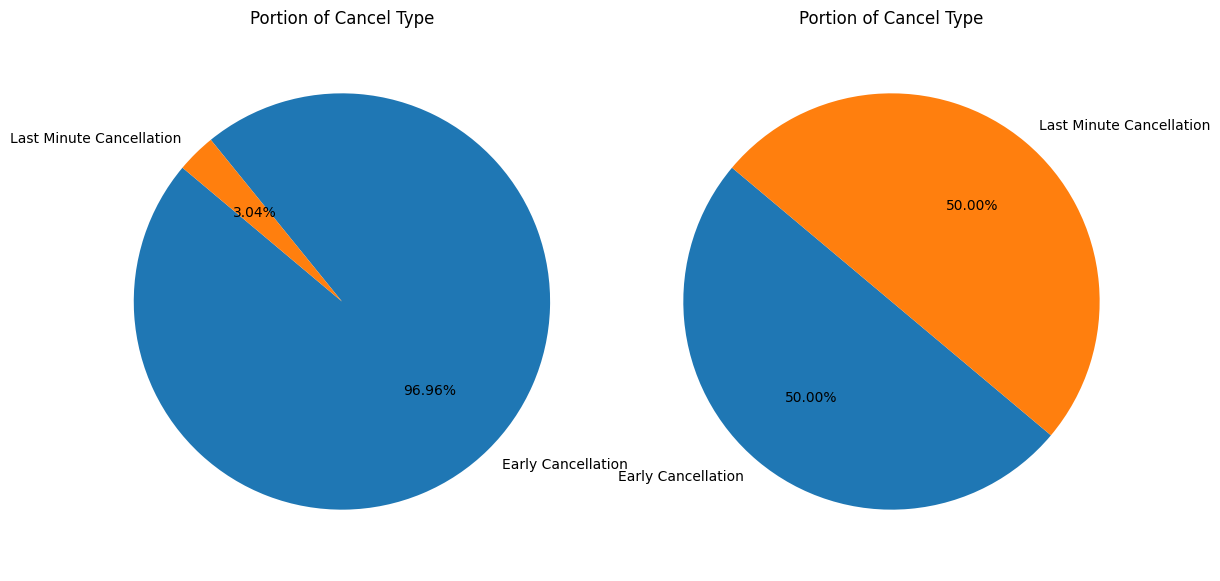

In [118]:
Counts_CancelType = y_train.value_counts()
Counts_CancelType_only_cancel = y_train_oversampled.value_counts()

# Plotting the pie chart of the portion of cancellation type
fig, axs = plt.subplots(1, 2, figsize=(13, 7))  # 2 rows, 2 columns
label_index = ["Early Cancellation", "Last Minute Cancellation"]
axs[0].pie(Counts_CancelType, labels=label_index , autopct='%1.2f%%', startangle=140)
axs[0].axis('equal') 
axs[0].set_title('Portion of Cancel Type')

label_index = ["Early Cancellation", "Last Minute Cancellation"]
axs[1].pie(Counts_CancelType_only_cancel, labels=label_index , autopct='%1.2f%%', startangle=140)
axs[1].axis('equal') 
axs[1].set_title('Portion of Cancel Type')

plt.show()

### Logistic Regression

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)

In [44]:
clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model 
clf.fit(X_train_oversampled, y_train_oversampled)


LogisticRegression(random_state=42, solver='liblinear')

Accuracy: 0.9629181781539702
Precision: 0.9696928697063997
Recall: 0.9927967862584846
F1 Score: 0.9811088295687885


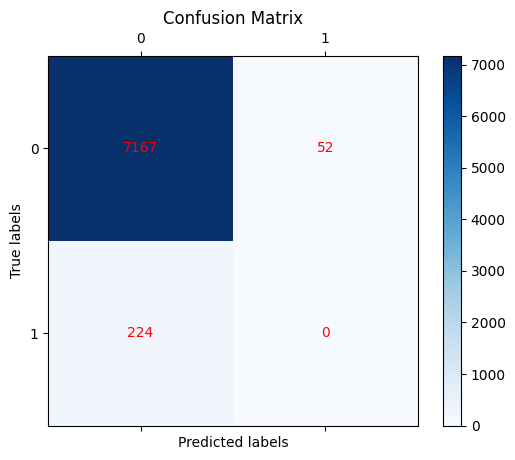

In [45]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')   
              
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

                                      Coefficient
TotalNights                              5.650911
BookingMeal_SC                           5.345558
BookingMeal_BB                           5.198707
CustomerType_Transient-Party             4.717887
MarketSegment_Offline TA/TO              4.252247
MarketSegment_Groups                     4.199176
BookingMeal_HB                           4.086002
MarketSegment_Online TA                  4.079493
CustomerType_Transient                   4.053712
CustomerType_Contract                    4.052826
DepositType_No Deposit                   3.894536
MarketSegment_Corporate                  3.839538
DepositType_Non Refund                   3.680963
AssignedRoom_A                           3.446298
AssignedRoom_D                           3.110748
DepositType_Refundable                   3.050678
AssignedRoom_B                           2.862549
AssignedRoom_G                           2.676475
NumberOfChildren                         2.669172


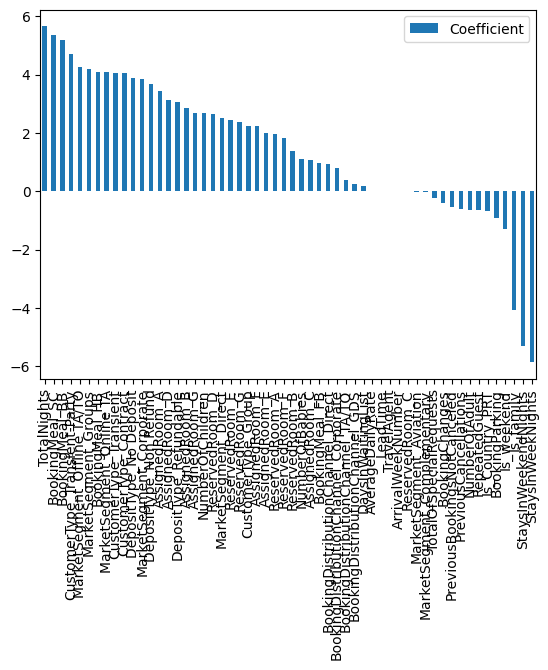

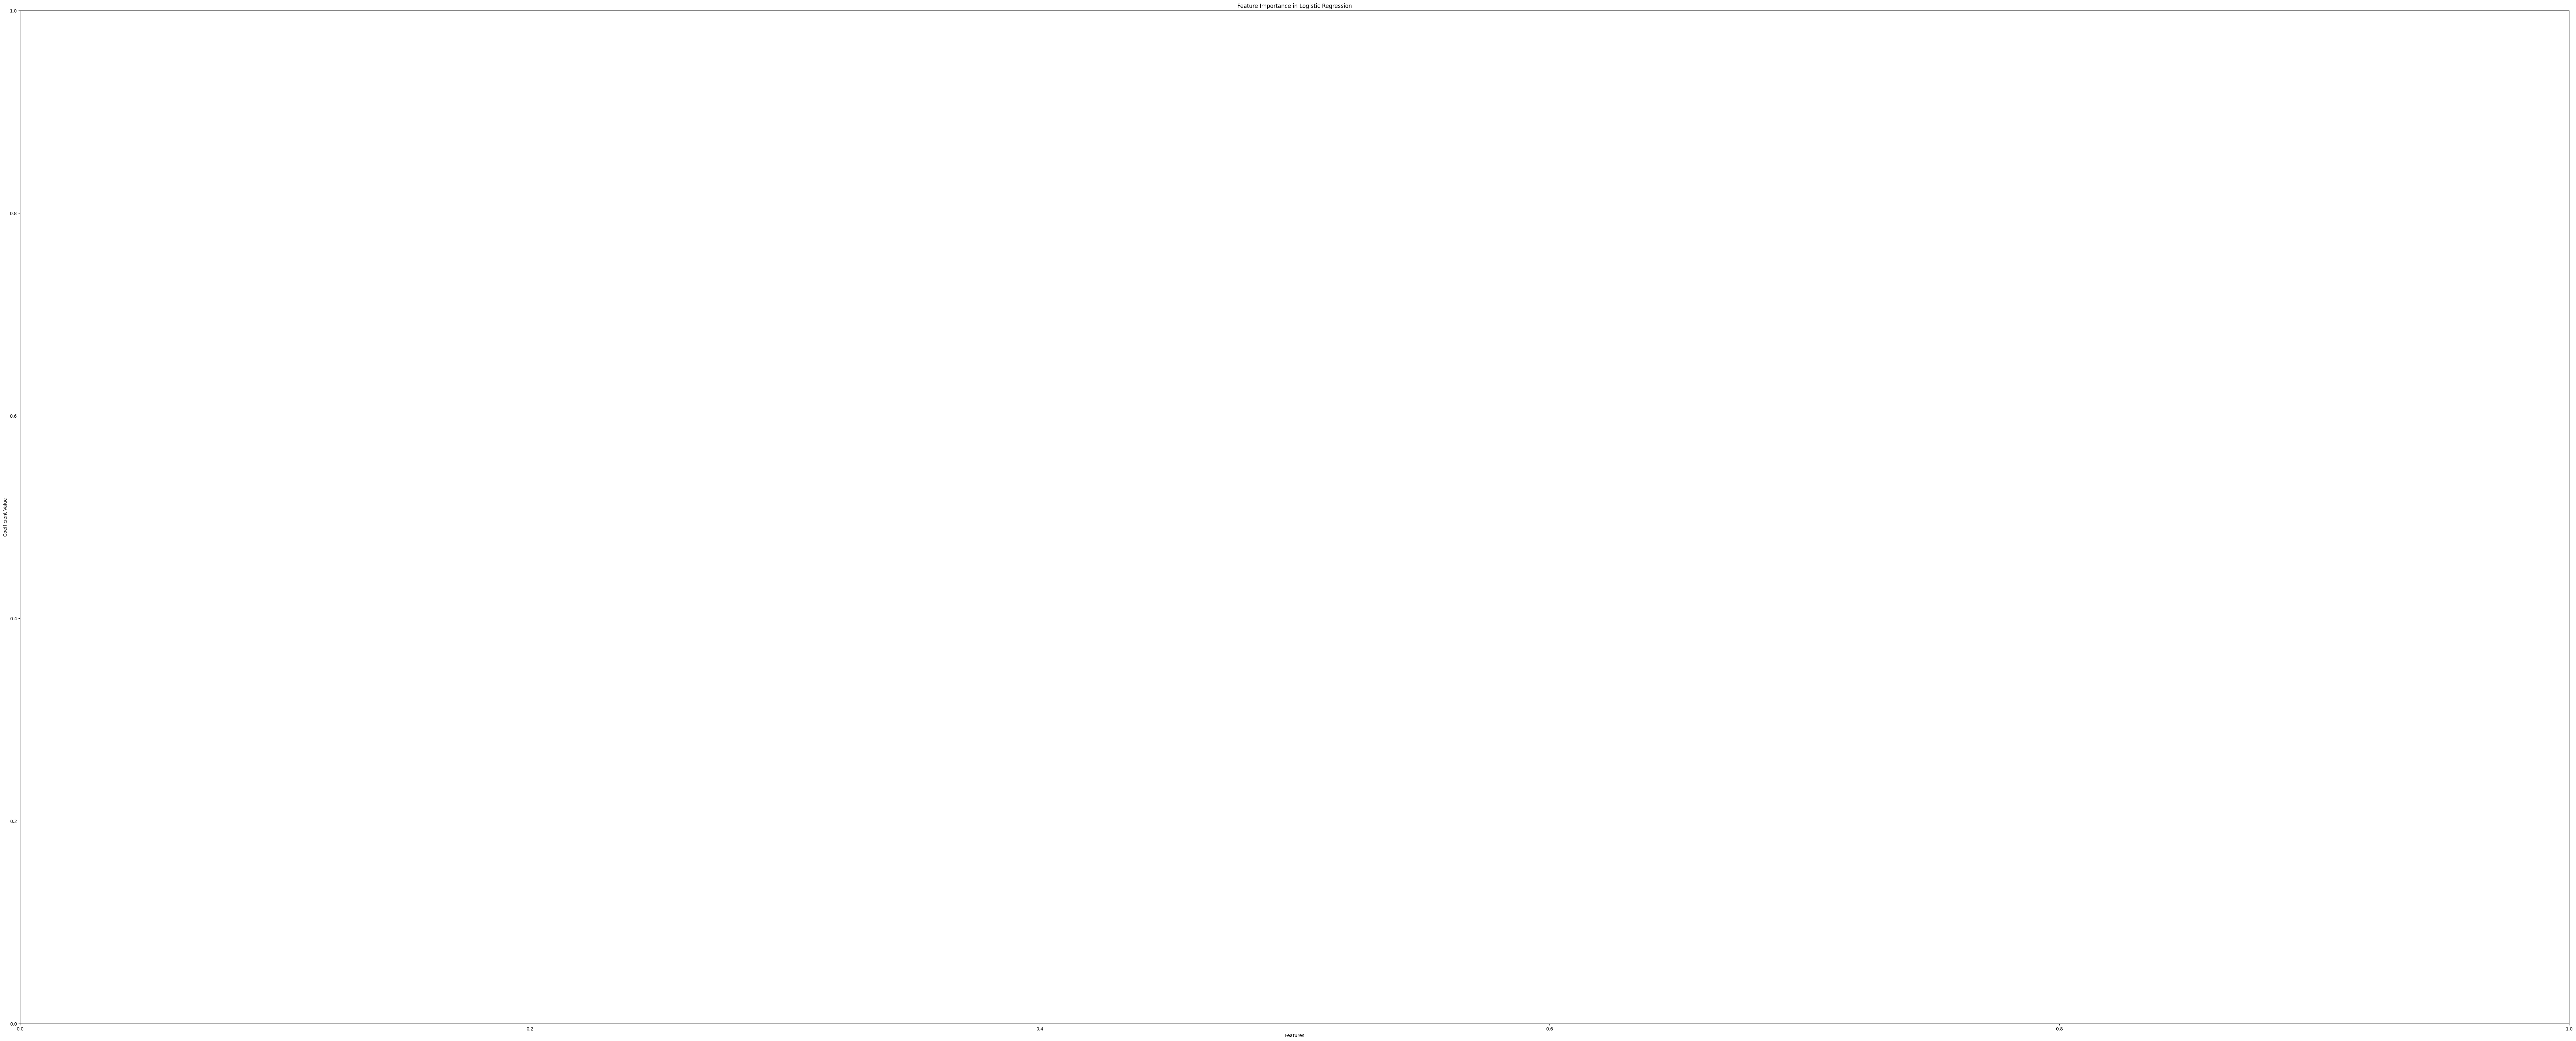

In [46]:
# Extract coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for easier interpretation
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

feature_importance.plot(kind='bar')
plt.figure(figsize=(100, 40))
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

### SVM

In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(kernel='linear', C=1.0) 
svm_clf.fit(X_train_oversampled, y_train_oversampled)

SVC(kernel='linear')

/Users/shenglienlee/anaconda3/envs/RIT_Competition/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Accuracy: 0.9686954185140401
Precision: 0.969994617868676
Recall: 0.99861476658817
F1 Score: 0.984096648692922


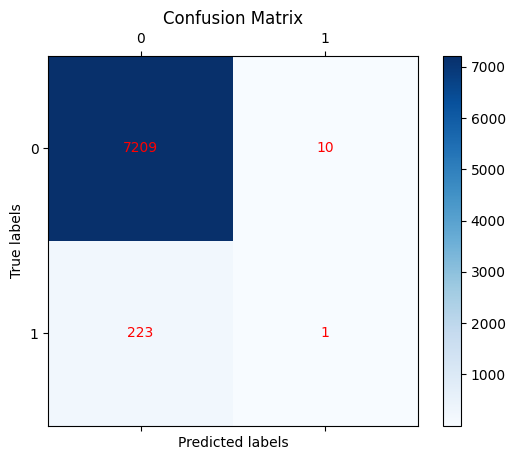

In [48]:
predictions = svm_clf.predict(X_test_scaled)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')   
              
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

In [49]:
# Get the weight coefficients
coefs = svm_clf.coef_[0]  # For binary classification, .coef_ is a 2D array

# The absolute value of the coefficients indicates importance
importance = np.abs(coefs)

# Example: Print the importance
print(importance)

[1.18371561e-03 3.38008582e-04 4.09821190e-02 4.89576980e-02
 2.62743719e-02 1.34510854e-03 6.59797138e-02 1.00000000e+00
 2.16870504e+00 6.52117863e-02 1.01146332e-01 1.63161209e-02
 2.57185018e+00 2.64951598e+00 3.26043245e-02 4.72115948e-04
 2.64311238e+00 1.77681576e-01 2.62813938e+00 6.52727115e-02
 2.35300359e+00 2.18114757e+00 1.48171592e+00 2.29226340e+00
 1.92156429e+00 2.02009841e+00 2.01214731e+00 1.98748133e+00
 5.16896933e-01 0.00000000e+00 2.08013116e+00 9.21564287e-01
 6.30302028e-01 9.20840080e-01 1.92295454e+00 2.00188946e+00
 1.90274016e+00 2.00499909e+00 2.75542029e+00 1.00000000e+00
 2.58991767e+00 2.76687777e+00 2.58958041e+00 1.00000000e+00
 2.65060029e+00 2.71122365e+00 2.62583939e+00 2.56603902e+00
 2.10781363e+00 0.00000000e+00 0.00000000e+00 2.58480368e+00
 2.29109018e+00 2.47799001e+00 2.50165645e+00 2.47383228e+00]


### Random Forest

In [50]:
clf = RandomForestClassifier(n_estimators=100, random_state=215)
clf.fit(X_train_oversampled, y_train_oversampled)

RandomForestClassifier(random_state=215)

Accuracy: 0.9660083299744726
Precision: 0.9706756756756757
Recall: 0.9950131597174123
F1 Score: 0.9826937547027841


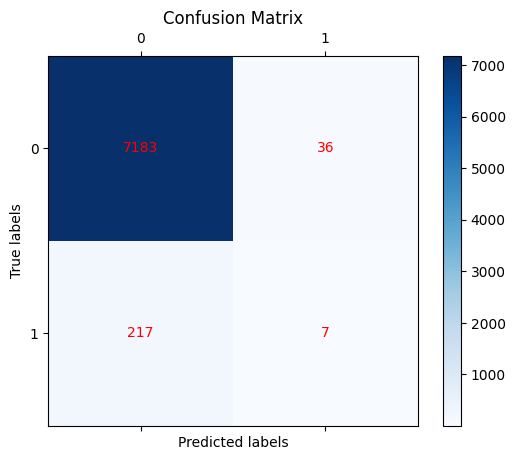

In [51]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 

print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

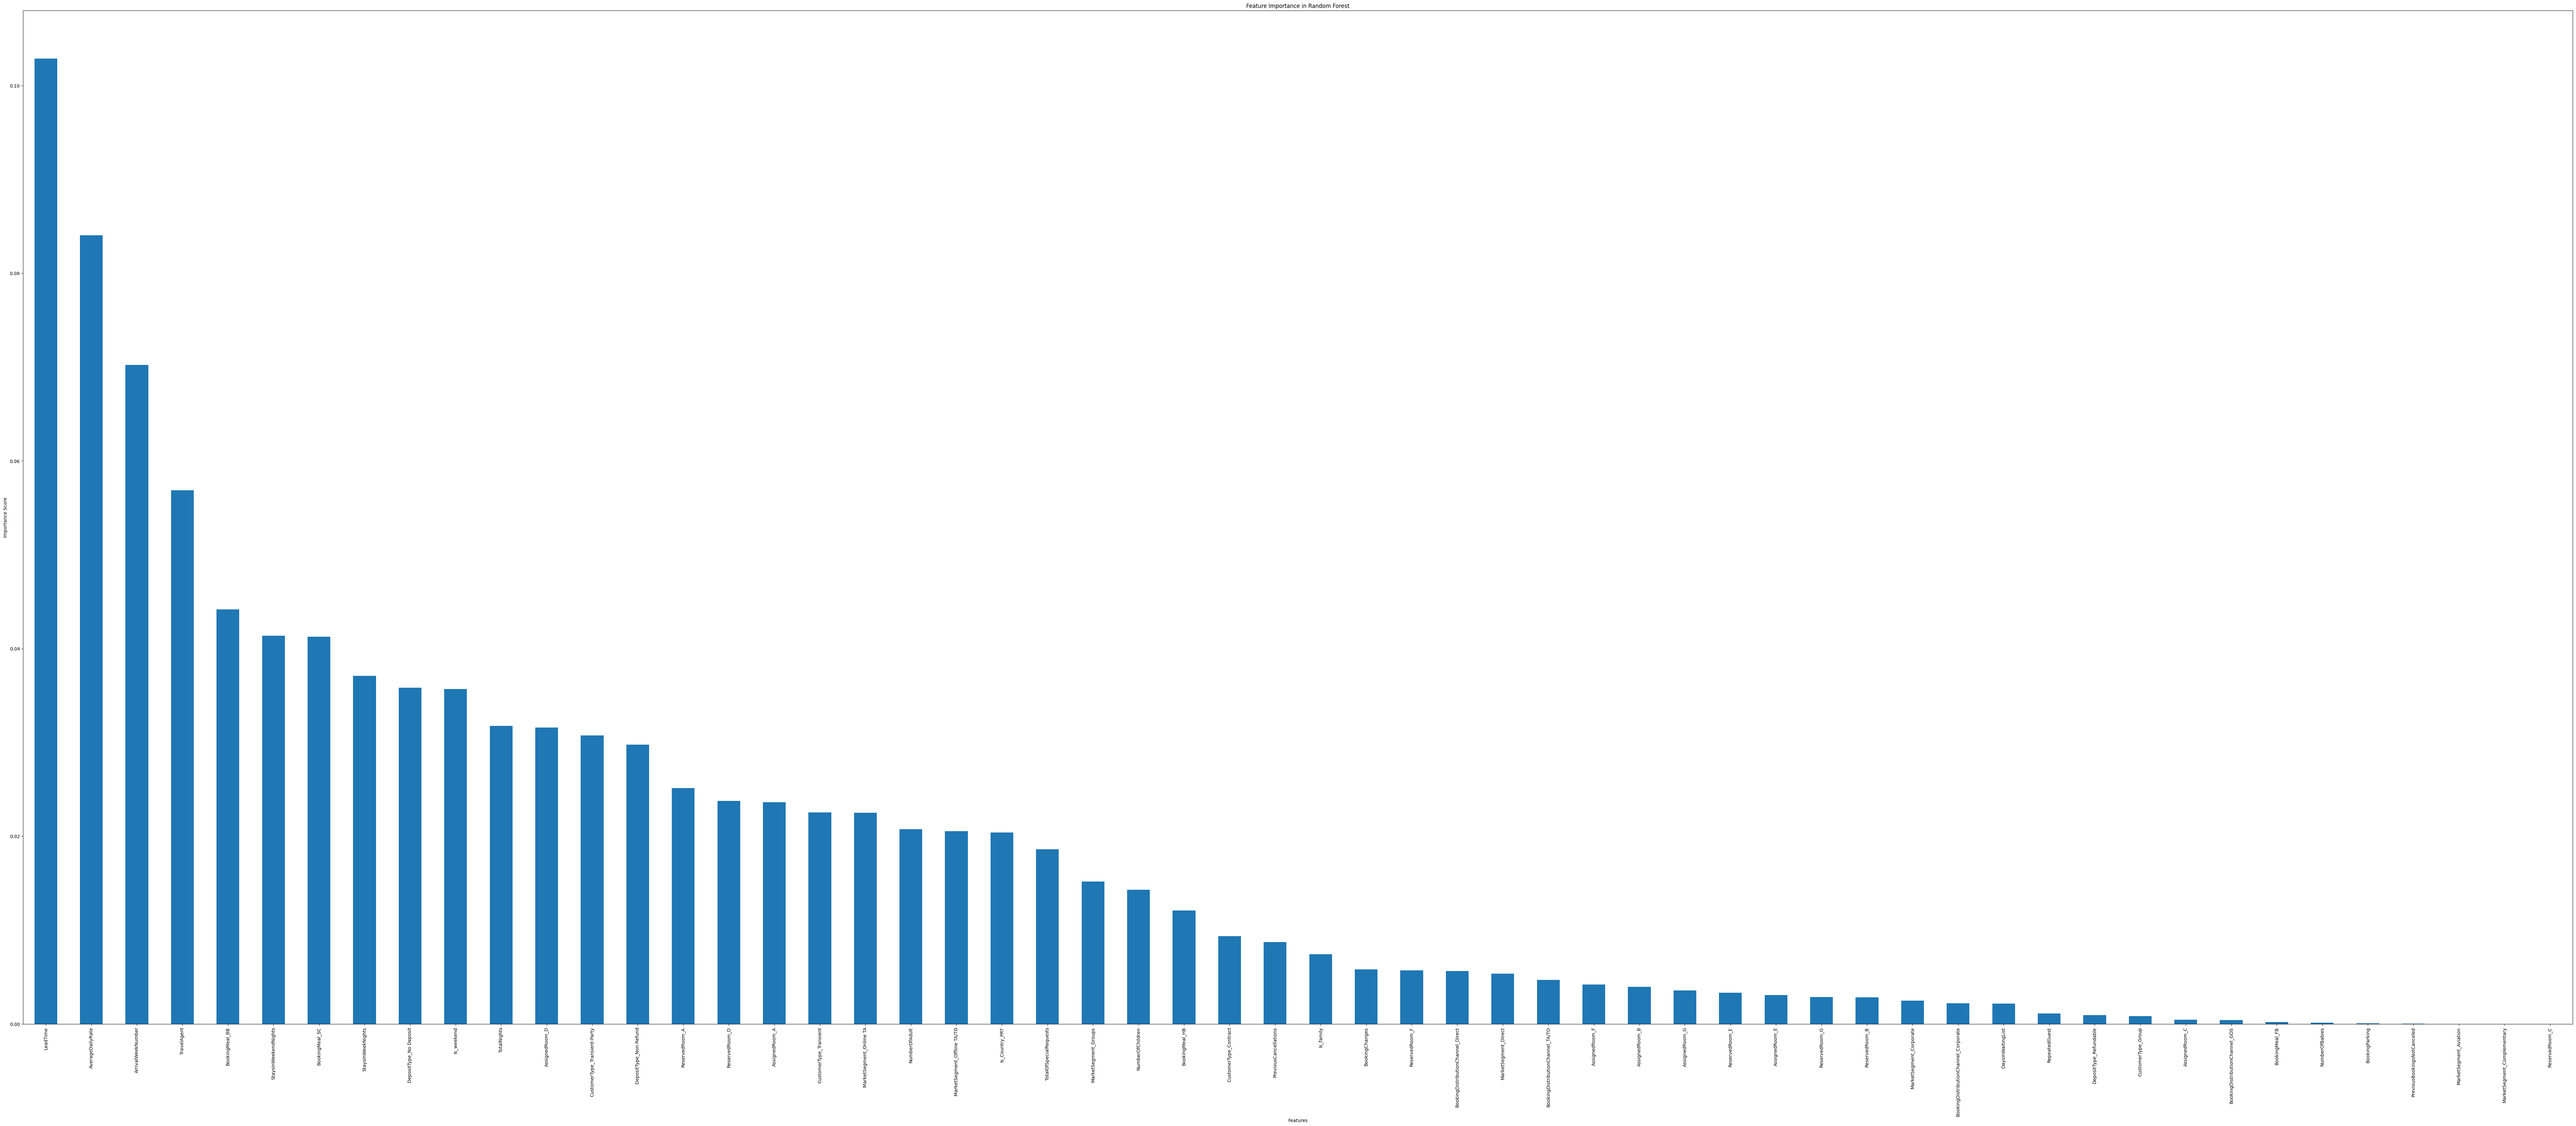

In [52]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series for easier plotting
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance in Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Features')

### XGboost

In [15]:
for i in range(len(y_train_oversampled)):
    y_train_oversampled[i] = y_train_oversampled[i] - 1

y_test = y_test.reset_index(drop=True)
for i in range(len(y_test)):
    y_test[i] = y_test[i] - 1

In [16]:
#XGBoost
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',enable_categorical = 'True')
clf.fit(X_train_oversampled, y_train_oversampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.9617089883111648
Precision: 0.0821917808219178
Recall: 0.026785714285714284
F1 Score: 0.04040404040404041


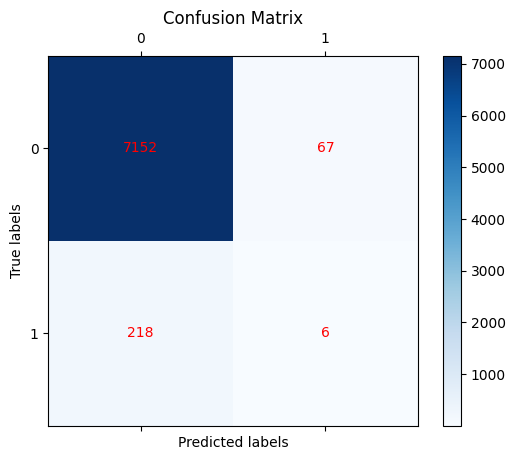

In [17]:
# Make predictions
predictions = clf.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 

print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

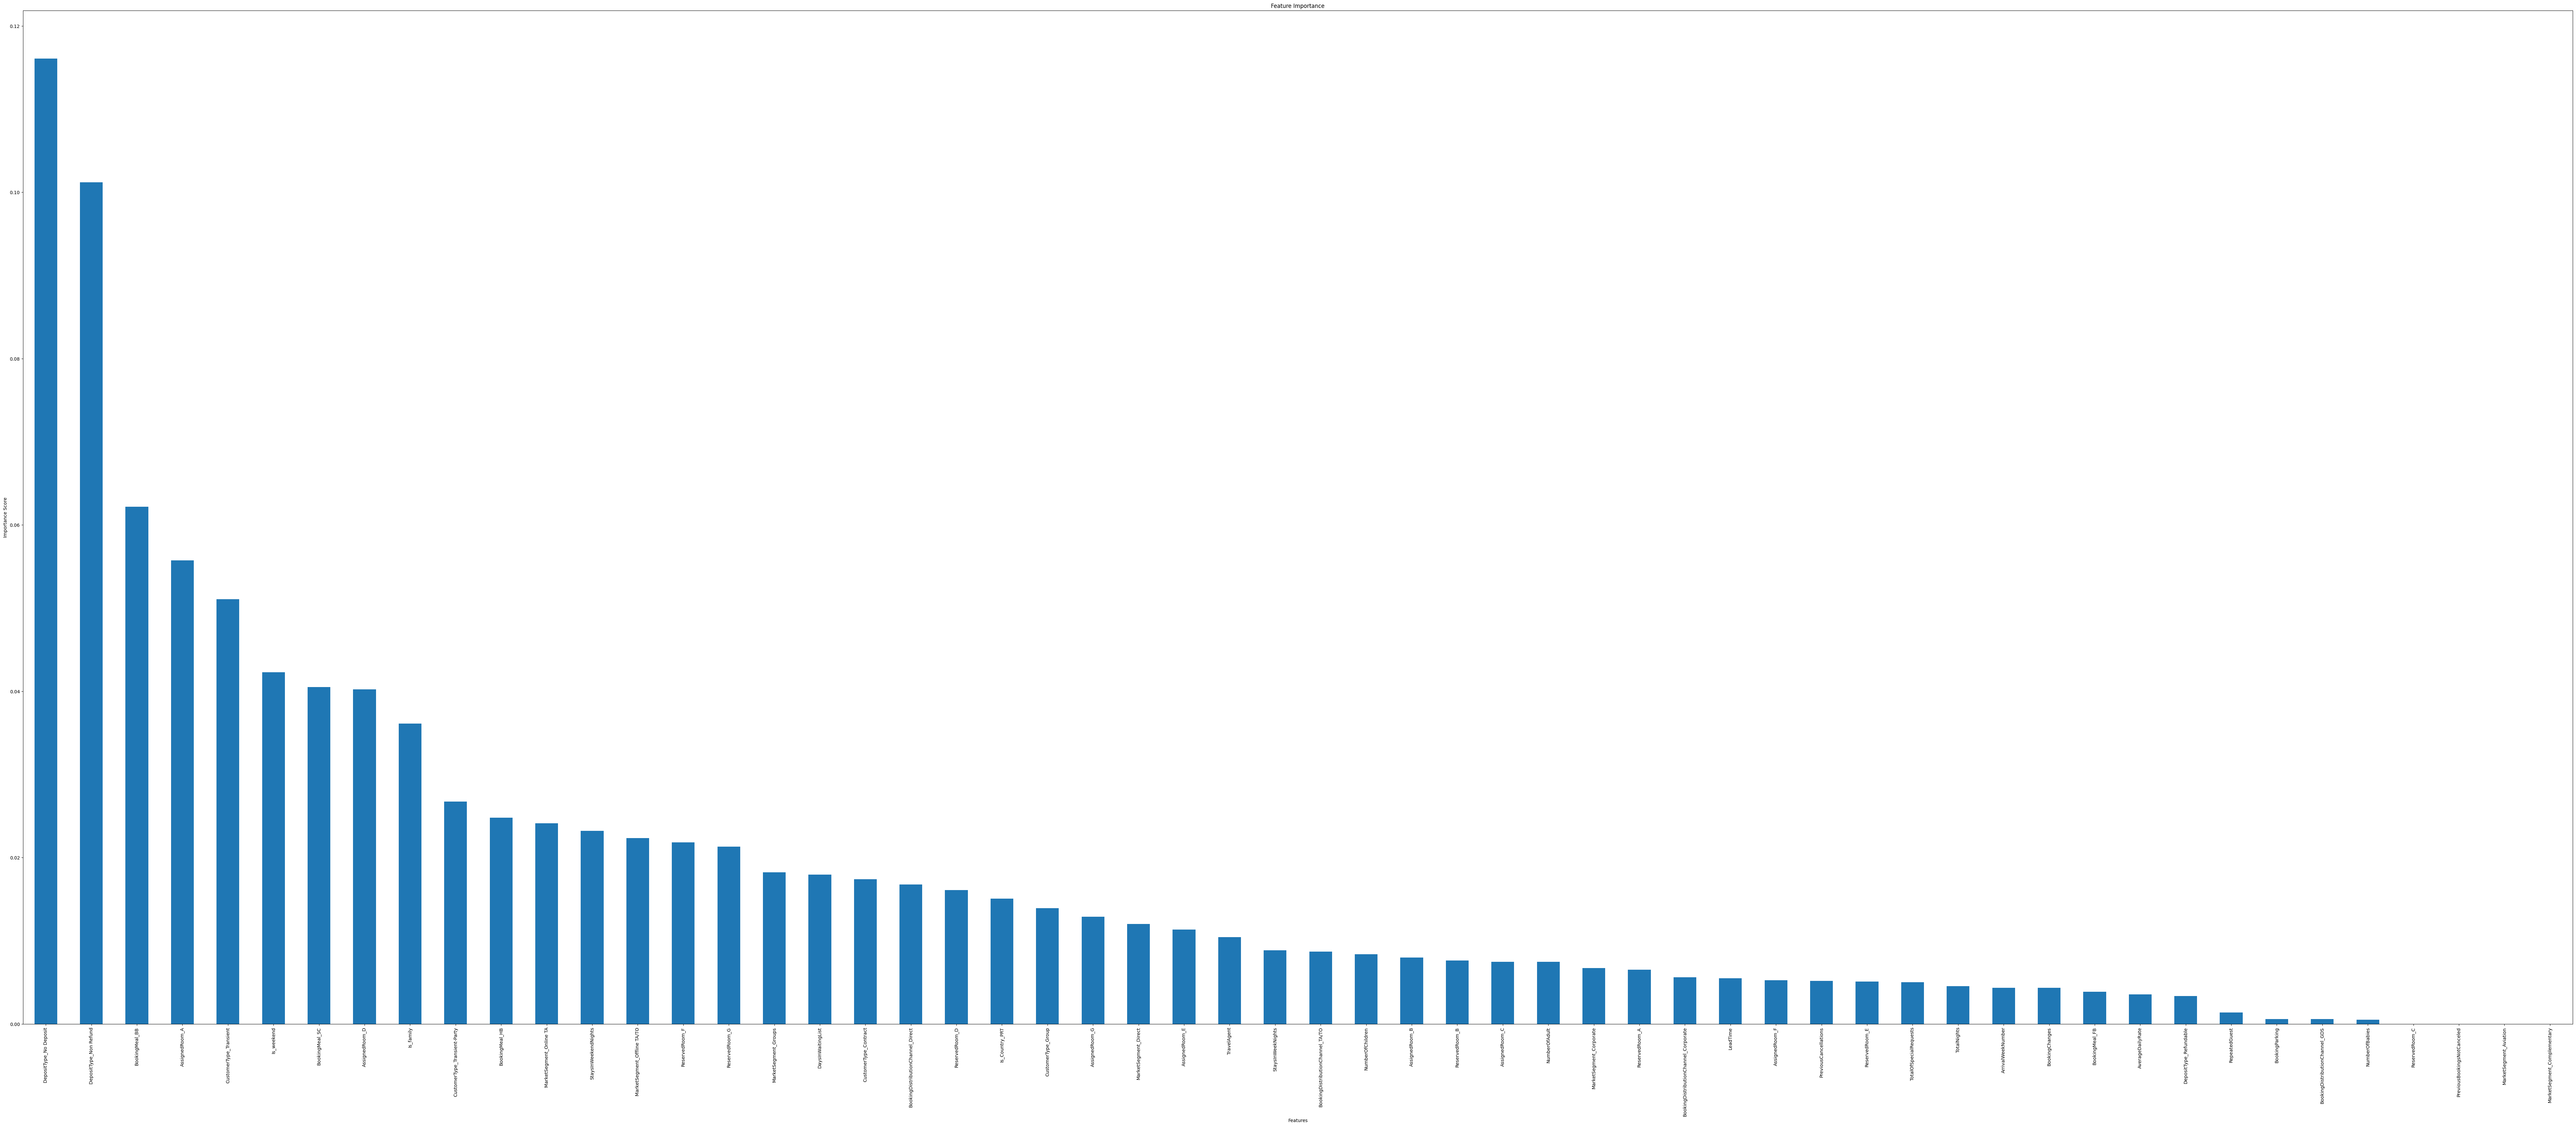

In [18]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series to make plotting easier
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')

## Undersampling

In [57]:
from imblearn.under_sampling import RandomUnderSampler

In [58]:
# If 'CancelType' is your target variable
y = Cancel_Data['CancelType']

# Drop the target variable from the feature set
X = Cancel_Data.drop('CancelType', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=215)
feature_names = X_train.columns

In [59]:
rus = RandomUnderSampler(random_state=42)
X_train_Undersampled, y_train_Undersampled = rus.fit_resample(X_train, y_train)

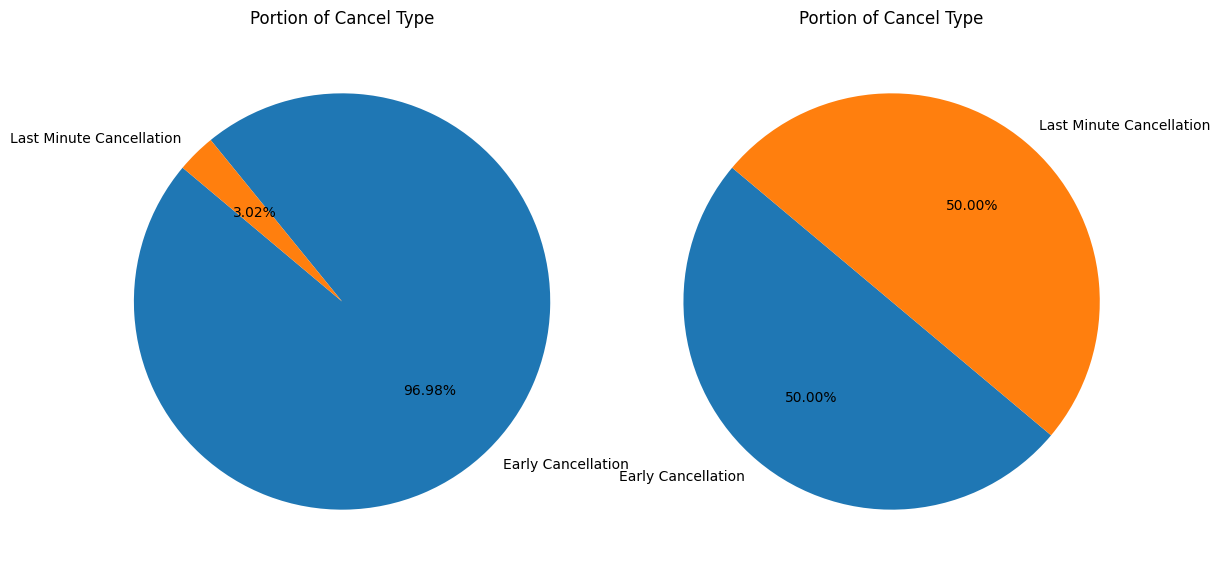

In [60]:
Counts_CancelType = y_train.value_counts()
Counts_CancelType_only_cancel = y_train_Undersampled.value_counts()

# Plotting the pie chart of the portion of cancellation type
fig, axs = plt.subplots(1, 2, figsize=(13, 7))  # 2 rows, 2 columns
label_index = ["Early Cancellation", "Last Minute Cancellation"]
axs[0].pie(Counts_CancelType, labels=label_index , autopct='%1.2f%%', startangle=140)
axs[0].axis('equal') 
axs[0].set_title('Portion of Cancel Type')

label_index = ["Early Cancellation", "Last Minute Cancellation"]
axs[1].pie(Counts_CancelType_only_cancel, labels=label_index , autopct='%1.2f%%', startangle=140)
axs[1].axis('equal') 
axs[1].set_title('Portion of Cancel Type')

plt.show()

In [61]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)

In [62]:
clf = LogisticRegression(solver='liblinear', random_state=42)
# Fit the model 
clf.fit(X_train_Undersampled, y_train_Undersampled)


LogisticRegression(random_state=42, solver='liblinear')

Accuracy: 0.5614671503426037
Precision: 0.9786976519002663
Recall: 0.5600498684028259
F1 Score: 0.7124229074889867


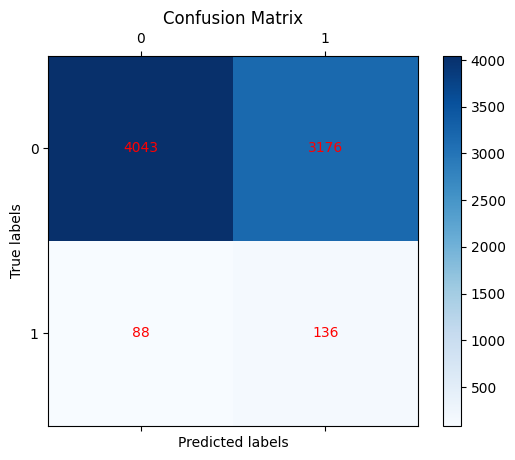

In [63]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')   
              
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

                                      Coefficient
AssignedRoom_B                           0.719968
AssignedRoom_G                           0.606342
RepeatedGuest                            0.460922
DepositType_Refundable                   0.397393
Is_Country_PRT                           0.394762
ReservedRoom_D                           0.368318
CustomerType_Transient-Party             0.287945
DaysInWaitingList                        0.277895
BookingDistributionChannel_Corporate     0.257407
ReservedRoom_A                           0.221872
DepositType_No Deposit                   0.210896
NumberOfBabies                           0.199329
BookingMeal_FB                           0.197936
MarketSegment_Corporate                  0.191301
MarketSegment_Groups                     0.191264
BookingMeal_SC                           0.175332
ReservedRoom_F                           0.171116
ReservedRoom_G                           0.159677
NumberOfChildren                         0.155796


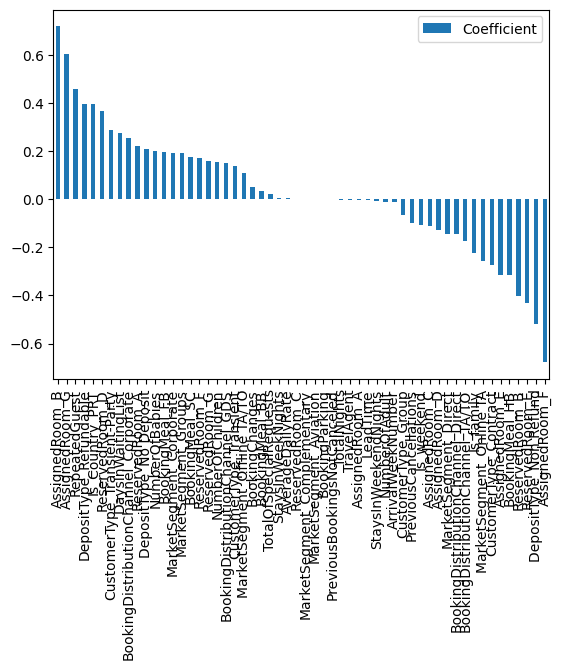

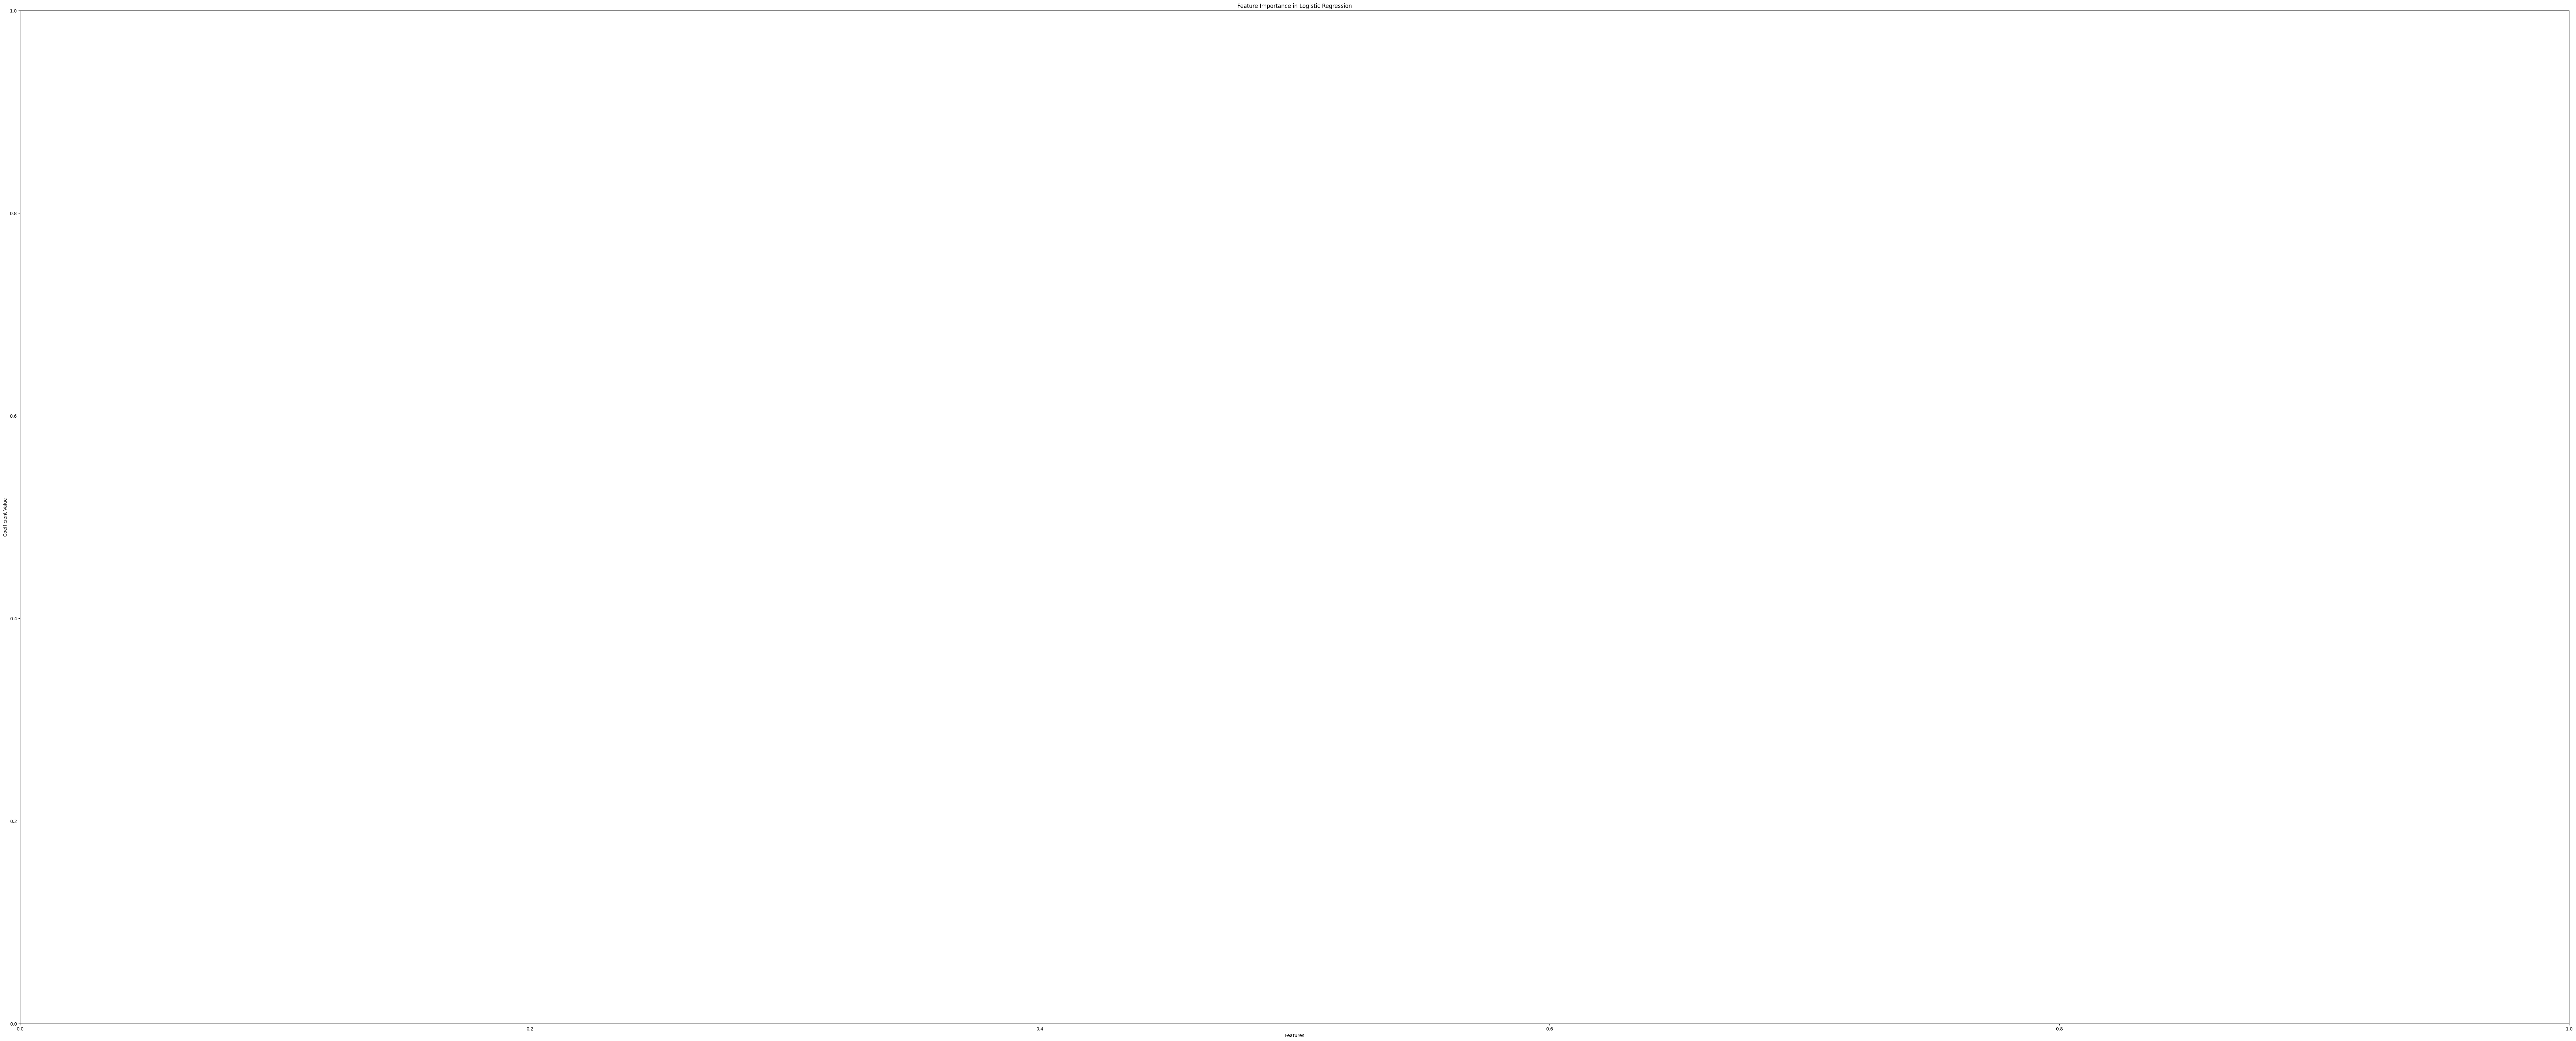

In [64]:
# Extract coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for easier interpretation
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)

feature_importance.plot(kind='bar')
plt.figure(figsize=(100, 40))
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

### SVM

In [65]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_Undersampled)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(kernel='linear', C=1.0) 
svm_clf.fit(X_train_Undersampled, y_train_Undersampled)

SVC(kernel='linear')

/Users/shenglienlee/anaconda3/envs/RIT_Competition/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Accuracy: 0.26803708182184605
Precision: 0.9732763228220203
Recall: 0.2522510042942236
F1 Score: 0.40066006600660065


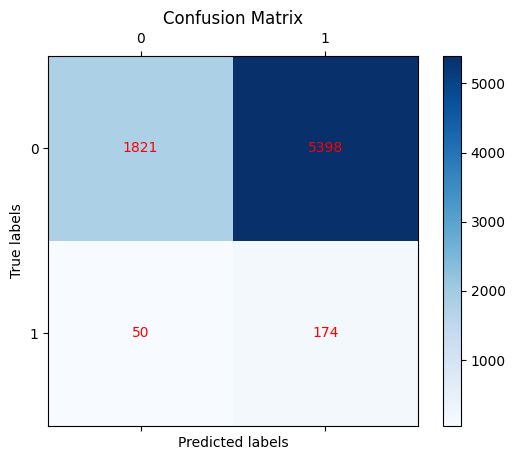

In [66]:
predictions = svm_clf.predict(X_test_scaled)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')   
              
print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

In [67]:
# Get the weight coefficients
coefs = svm_clf.coef_[0]  # For binary classification, .coef_ is a 2D array

# The absolute value of the coefficients indicates importance
importance = np.abs(coefs)

# Example: Print the importance
print(importance)

[0.0109538  0.0052416  0.01565156 0.         0.15114175 0.00728747
 0.02825818 0.         0.07804356 0.         0.04164058 0.37118098
 0.1069154  0.04736045 0.02743578 0.00409832 0.07899575 0.13183427
 0.05955495 0.4049742  0.00200472 0.87685729 0.         0.0389751
 0.53099079 0.783078   0.47819132 0.40215403 0.49314781 0.
 0.49997346 0.53099079 0.1220111  0.         0.22266238 0.15602217
 0.07072345 0.13736366 0.14837761 0.         0.54544551 0.39706791
 0.39664958 0.         0.13318843 0.26346115 0.0700759  0.69836077
 0.62828486 0.         0.         0.22266238 0.15602217 0.19425905
 0.111198   0.37209725]


### Random Forest

In [68]:
clf = RandomForestClassifier(n_estimators=100, random_state=215)
clf.fit(X_train_Undersampled, y_train_Undersampled)

RandomForestClassifier(random_state=215)

Accuracy: 0.5599892516458417
Precision: 0.9779447406689288
Recall: 0.558941681673362
F1 Score: 0.7113265755839577


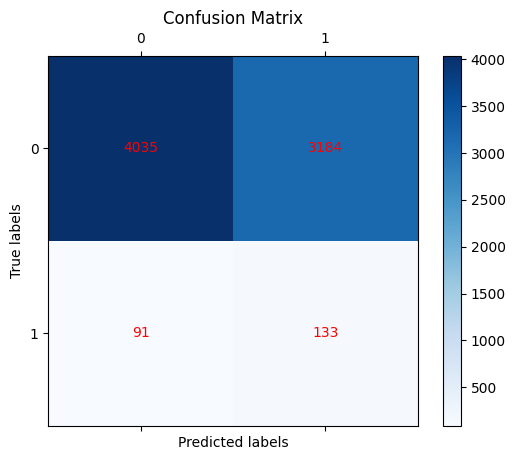

In [69]:
predictions = clf.predict(X_test)
# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 

print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

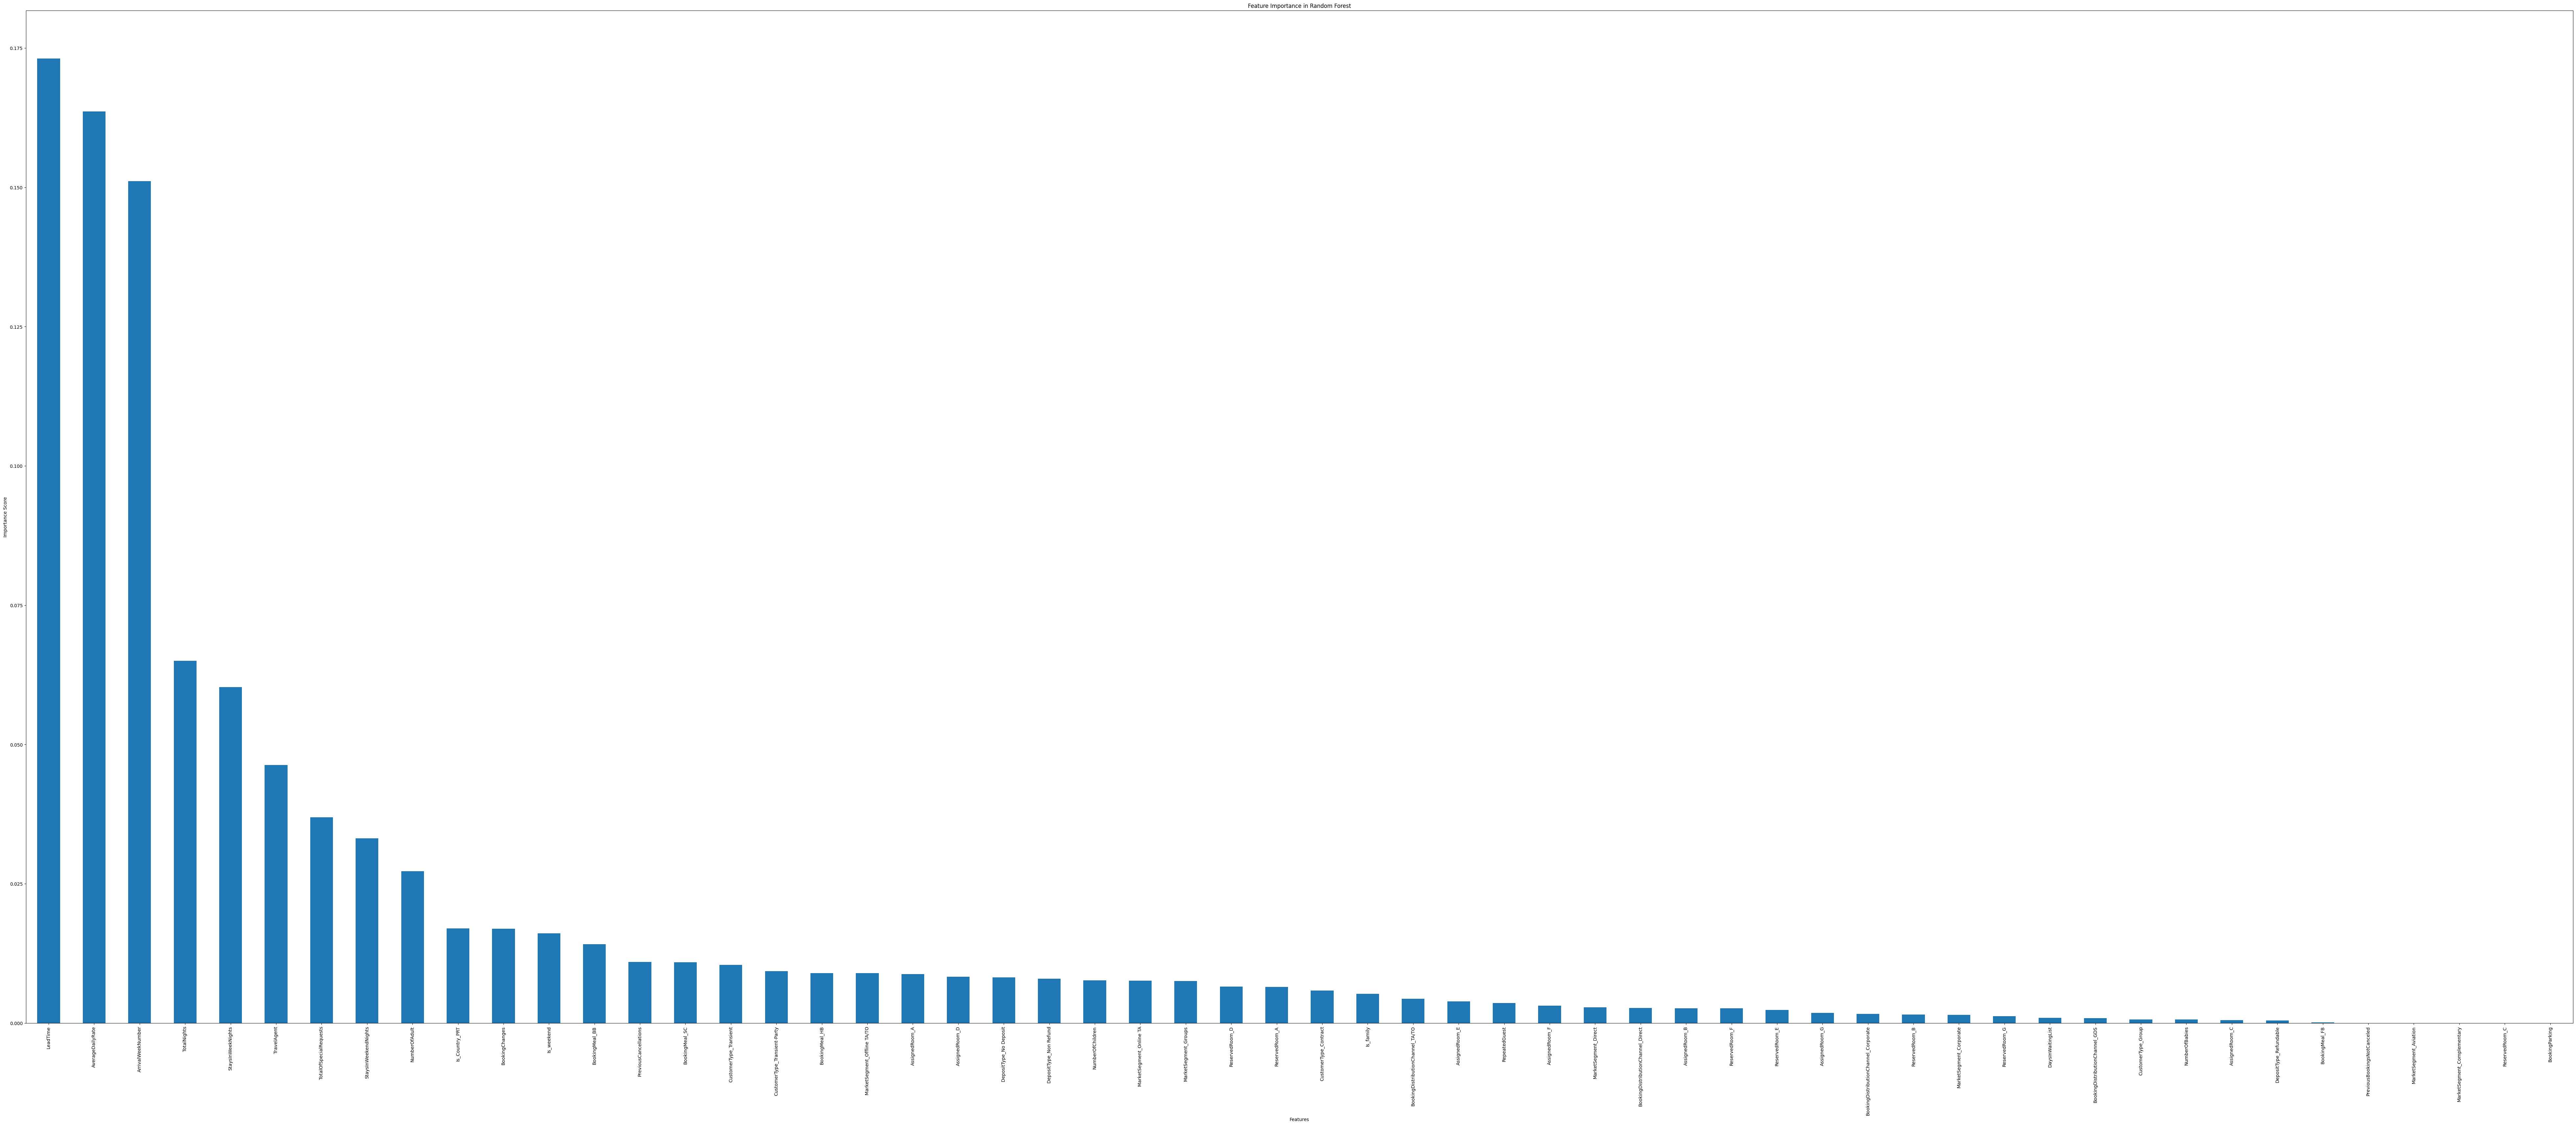

In [70]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series for easier plotting
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance in Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Features')

### XGboost

In [72]:
y_train_Undersampled=y_train_Undersampled.reset_index(drop=True)
for i in range(len(y_train_Undersampled)):
    y_train_Undersampled[i] = y_train_Undersampled[i] - 1

y_test = y_test.reset_index(drop=True)
for i in range(len(y_test)):
    y_test[i] = y_test[i] - 1

In [73]:
#XGBoost
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',enable_categorical = 'True')
clf.fit(X_train_Undersampled, y_train_Undersampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical='True', eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.5630794034663442
Precision: 0.038695917123705056
Recall: 0.5669642857142857
F1 Score: 0.07244723331431831


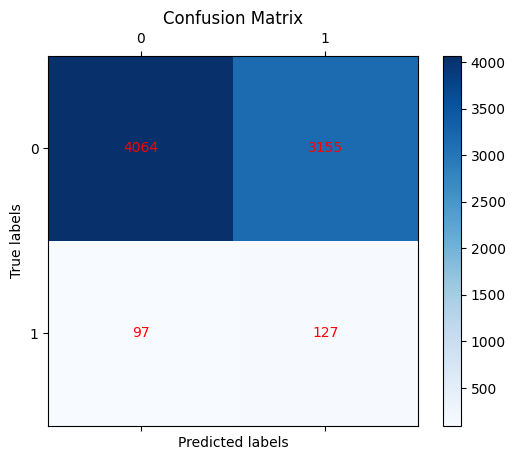

In [74]:
# Make predictions
predictions = clf.predict(X_test)

# Evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')  
recall = recall_score(y_test, predictions, average='binary')        
f1 = f1_score(y_test, predictions, average='binary')                 

print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plotting using matplotlib
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Adding text labels for each cell in the matrix
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

plt.show()

Text(0.5, 0, 'Features')

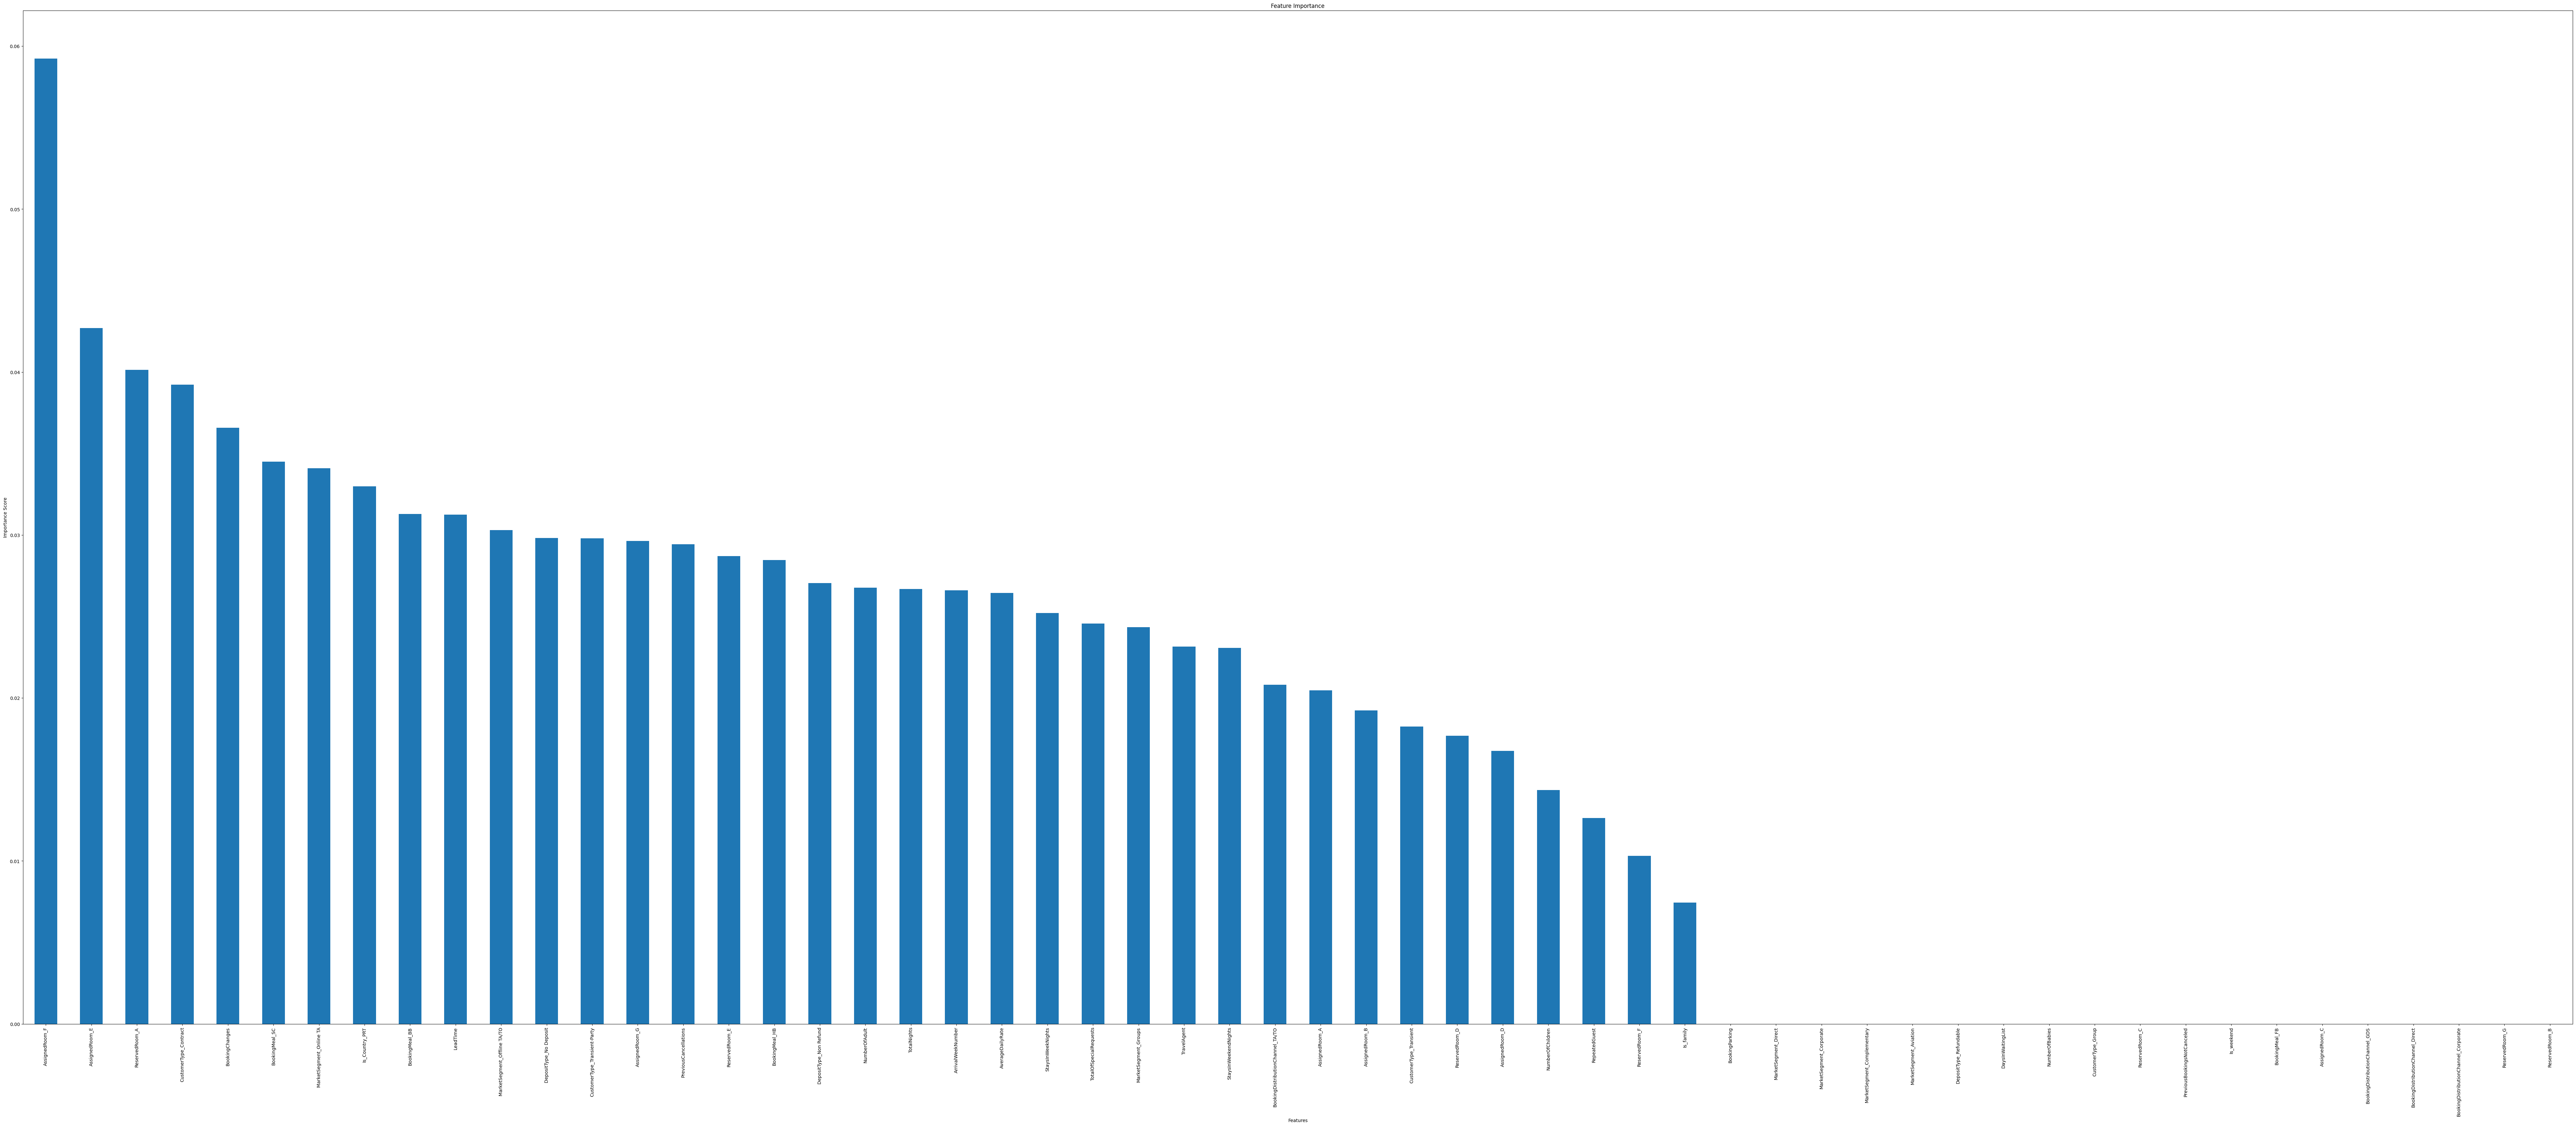

In [75]:
# Get feature importances
feature_importances = clf.feature_importances_

# Create a pandas series to make plotting easier
features = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)
#show the top 30 important features
#features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)[:30]

# Plotting
plt.figure(figsize=(100, 40))
features.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance Score')
plt.xlabel('Features')

## Next

### different threadshold
### different algorithm